# Seattle Airbnb Exploration

## Table of Contents
<ol>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#gather">Gather</a></li>
    <li><a href="#assess">Assess</a>
    <ol type="1">
        <li><a href="#calendar">Calendar</a></li>
        <li><a href="#listings">Listings</a></li>
        <li><a href="#reviews">Reviews</a></li>
    </ol></li>
    <li><a href="#business">Business Understanding</a></li>
    <li><a href="#data">Data Understanding</a>
    <ol type="1">
        <li><a href="#listing">Calendar Information</a></li>
        <li><a href="#host">Listings Information</a></li>
        <li><a href="#review">Reviews Information</a></li>
        <li><a href="#date">Date Information</a></li>
    </ol></li>
    <li><a href="#prep">Data Preparation</a>
    <ol type="1">
        <li><a href="#clean">Cleaning</a>
        <ol type="1">
            <li><a href="#zipcode">Missing zipcodes</a></li>
            <li><a href="#join">Join datasets</a></li>
            <li><a href="#unnecessary">Drop unnecessary columns</a></li>
            <li><a href="#rows">Drop specified rows with missing values</a></li>
            <li><a href="#str">Convert columns to `str`</a>
            <li><a href="#bool">Convert columns to `1`, `0`</a></li>
            <li><a href="#price">Convert price/percent columns to `float`</a></li>
            <li><a href="#datetime">Convert columns to `datetime`</a></li>
            <li><a href="#unix">Convert `host_since` to unix time</a></li>
            <li><a href="#amen">Extract amenities</a></li>
            <li><a href="#remain">Manage remaining columns</a>
        </ol></li>
        <li><a href="#engineer">Feature Engineering</a>
        <ol type="1">
            <li><a href="#split">Train-Test Split</a></li>
            <li><a href="#skew">Review distribution skew</a></li>
            <li><a href="#cat">Convert categorical columns to dummies</a></li>
            <li><a href="#date-feat">Create date dummies</a></li>
            <li><a href="#text">Text extraction</a>
            <li><a href="#missing">Explore missing values</a></li>
            <li><a href="#function">Create engineering function</a></li>
        </ol></li>
    </ol></li>
    <li><a href="#model">Modeling</a>
    <ol type="1">
        <li><a href="#select">Metrics and Model Selection</a></li>
        <li><a href="#initial">Initial Evaluation</a></li>
    </ol></li>
</ol>

<a id='intro'></a>
## 1. Introduction
The data explored in this notebook was obtained from the [Seattle Airbnb Open Data](https://www.kaggle.com/airbnb/seattle/data) Kaggle site. The data contains information about the availability of the listings, the characteristics of the listing and host, and reviews provided by guests staying at the listing for 2016. 

It will be explored implementing the Cross-Industry Standard Process for Data Mining (CRISP-DM) process as part of the Write a Data Science Blog Post project requirements for Udacity's Data Scientist Nanodegree. The CRISP-DM process encompasses six elements:
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

The data will be gathered and initial exploration completed to enable the first two elements to be completed. Deployment will take the form of a blog post targeted at a general audience, informing them of the action items.

<a id='gather'></a>
## 2. Gather

In [260]:
from datetime import datetime, timedelta
import itertools
import os
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from missingpy import KNNImputer
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import fbeta_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.svm import SVC
import xgboost as xgb

%matplotlib inline

In [21]:
# Download data - requires saved Kaggle API key to run: https://github.com/Kaggle/kaggle-api
!kaggle datasets download -d airbnb/seattle


  0%|          | 0.00/19.5M [00:00<?, ?B/s]
  5%|5         | 1.00M/19.5M [00:01<00:21, 918kB/s]
 10%|#         | 2.00M/19.5M [00:02<00:19, 921kB/s]
 15%|#5        | 3.00M/19.5M [00:03<00:18, 927kB/s]
 21%|##        | 4.00M/19.5M [00:04<00:17, 931kB/s]
 26%|##5       | 5.00M/19.5M [00:05<00:16, 934kB/s]
 31%|###       | 6.00M/19.5M [00:06<00:15, 936kB/s]
 36%|###5      | 7.00M/19.5M [00:07<00:13, 938kB/s]
 41%|####1     | 8.00M/19.5M [00:08<00:12, 939kB/s]
 46%|####6     | 9.00M/19.5M [00:10<00:12, 910kB/s]
 51%|#####1    | 10.0M/19.5M [00:11<00:10, 919kB/s]
 57%|#####6    | 11.0M/19.5M [00:12<00:09, 925kB/s]
 62%|######1   | 12.0M/19.5M [00:13<00:08, 930kB/s]
 67%|######6   | 13.0M/19.5M [00:14<00:07, 933kB/s]
 72%|#######1  | 14.0M/19.5M [00:15<00:06, 933kB/s]
 77%|#######7  | 15.0M/19.5M [00:16<00:05, 935kB/s]
 82%|########2 | 16.0M/19.5M [00:18<00:03, 937kB/s]
 87%|########7 | 17.0M/19.5M [00:19<00:02, 939kB/s]
 92%|#########2| 18.0M/19.5M [00:20<00:01, 910kB/s]
 98%|#########7| 19

In [24]:
# Unzip files
with ZipFile('seattle.zip', 'r') as zip_file:
    zip_file.extractall()

<a id='assess'></a>
## 3. Assess

In [60]:
# Read in files
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

<a id="calendar"></a>
### 3.1. Calendar

In [26]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


The dataset contains info on the availability lists per id by date, including if the id was available and the listing price. 

In [27]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


The dataset contains 4 columns and almost 1.4M rows of data.

#### Data Issues Identified
- **listing_id**: <span style="color:green">convert to `str`</span>
- **date**: <span style="color:green"> convert to `datetime`</span>
- **available**: <span style="color:green">convert to dummy</span>
- **price**: <span style="color:green">drop $ and convert to float/int</span>

The only feature with missing values is price but it is possible that this is only the case when the listing is unavailable. 

In [28]:
# Check if number of missing values is the same as number of 'f' availability
assert calendar.price.isna().sum() == calendar.query('available == "f"').shape[0]

It's helpful to check the range of the data for any errors, but due to the current datatypes, some will have to occur after cleaning. We can check values for `available` and `price`.

In [29]:
calendar.available.value_counts()

t    934542
f    459028
Name: available, dtype: int64

In [30]:
calendar.price.value_counts()

$150.00    36646
$100.00    31755
$75.00     29820
$125.00    27538
$65.00     26415
$90.00     24942
$95.00     24327
$99.00     23629
$85.00     23455
$80.00     19817
$110.00    19454
$120.00    19145
$70.00     18439
$60.00     18004
$175.00    17707
$250.00    16870
$55.00     16864
$200.00    16144
$50.00     15978
$115.00    14775
$40.00     13357
$69.00     12922
$135.00    11455
$105.00    11062
$130.00    11008
$89.00     10355
$79.00     10133
$225.00     8163
$45.00      8134
$129.00     8111
           ...  
$745.00        1
$743.00        1
$669.00        1
$722.00        1
$652.00        1
$788.00        1
$693.00        1
$527.00        1
$817.00        1
$481.00        1
$625.00        1
$583.00        1
$711.00        1
$663.00        1
$723.00        1
$10.00         1
$567.00        1
$780.00        1
$503.00        1
$501.00        1
$737.00        1
$794.00        1
$517.00        1
$603.00        1
$616.00        1
$566.00        1
$624.00        1
$12.00        

It appears that while a decimal point is included in the prices, no price actually include cents. Based on what can be viewed above, the lowest price is around \$12 while the highest price ranges close to \$800.

It's also worth doing a quick double check of duplicates (though they are not expected).

In [34]:
calendar.duplicated().sum()

0

This is the only duplicate check that is relevant - all individual columns are expected to have duplicates, but as long as each row is unique, the data is as expected. 

<a id="listings"></a>
### 3.2. Listings

In [43]:
pd.set_option('display.max_columns', 100)
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [32]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [33]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [37]:
# Check if all rows have unique IDs
listings.id.nunique()

3818

Yes, all are unique.

In [36]:
# What is in "experiences_offered"?
listings.experiences_offered.unique()

array(['none'], dtype=object)

Doesn't matter because all values are none - can drop.

In [38]:
# Are there less host ids?
listings.host_id.nunique()

2751

This means that some hosts have multiple listings.

In [40]:
# Check if host id and url have same number unique
assert listings.host_id.nunique() == listings.host_url.nunique()

Can drop `host_url` because won't be using for interpretation.

In [42]:
# Check if host id and name have same number unique
print(listings.host_id.nunique())
print(listings.host_name.nunique())

2751
1466


Of course they aren't - many people share the same name!

In [45]:
# Check host locations
listings.host_location.unique()

array(['Seattle, Washington, United States',
       'Kirkland, Washington, United States',
       'Quilcene, Washington, United States', 'US', nan,
       'Lowell, Massachusetts, United States',
       'Sammamish, Washington, United States',
       'Los Angeles, California, United States',
       'Shoreline, Washington, United States',
       'Portland, Oregon, United States',
       'San Francisco, California, United States',
       'Berkeley, California, United States',
       'Greenwood Village, Colorado, United States',
       'Ciudad Obregón, Sonora, Mexico',
       'Mercer Island, Washington, United States',
       'Prescott Valley, Arizona, United States',
       'Long Beach, California, United States',
       'San Diego, California, United States', 'SG',
       'Breckenridge, Colorado, United States',
       'Massachusetts, United States', 'Addison, Texas, United States',
       'Kent, Washington, United States',
       'Newcastle, Washington, United States',
       'Tucson, Ar

In [46]:
# Check response times
print(listings.host_response_time.nunique())
listings.host_response_time.unique()

4


array(['within a few hours', 'within an hour', nan, 'within a day',
       'a few days or more'], dtype=object)

Four levels, easy to dummy.

In [47]:
# Check values for acceptance rate
listings.host_acceptance_rate.value_counts()

100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64

Value counts are not very interesting, perhaps just create dummy for missing.

In [48]:
# Explore missing values for superhost
listings[listings.host_is_superhost.isna()]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1297,8354452,https://www.airbnb.com/rooms/8354452,20160104002432,2016-01-04,The View | Be Inspired in Seattle,A studio with stunning waterfront view worth t...,Looking for that perfect spot to take-in all o...,A studio with stunning waterfront view worth t...,none,This spot is in Belltown across the street fro...,Please accept my apologies for not being able ...,Seattle has a lot of transportation options in...,https://a2.muscache.com/ac/pictures/6d46a5de-9...,https://a2.muscache.com/im/pictures/6d46a5de-9...,https://a2.muscache.com/ac/pictures/6d46a5de-9...,https://a2.muscache.com/ac/pictures/6d46a5de-9...,42515980,https://www.airbnb.com/users/show/42515980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,"Western Avenue, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.616705,-122.353969,t,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$99.00,$725.00,NaN,NaN,$25.00,1,$25.00,2,13,2 months ago,t,30,60,89,89,2016-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN
1419,10235014,https://www.airbnb.com/rooms/10235014,20160104002432,2016-01-04,Luxury Apartment in Belltown / SLU,Beautiful building near the heart of downtown ...,NaN,Beautiful building near the heart of downtown ...,none,NaN,NaN,NaN,https://a2.muscache.com/ac/pictures/2644576c-4...,https://a2.muscache.com/im/pictures/2644576c-4...,https://a2.muscache.com/ac/pictures/2644576c-4...,https://a2.muscache.com/ac/pictures/2644576c-4...,1075031,https://www.airbnb.com/users/show/1075031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,"6th Avenue, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.615974,-122.340537,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$250.00,"$1,200.00","$3,600.00",NaN,NaN,1,$0.00,1,1125,a week ago,t,3,3,3,3,2016-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN


I'm going to drop the these two values because I don't understand why this information is missing. 

In [50]:
# Explore host neighbourhood
print(listings.host_neighbourhood.nunique())
listings.host_neighbourhood.unique()

102


array(['Queen Anne', nan, 'Ballard', 'Belltown', 'Phinney Ridge', 'Alki',
       'Fremont', 'Holly', 'Lower Queen Anne', 'Green Lake', 'Eastlake',
       'Ravenna', 'Westlake', 'Columbia City', 'South Park', 'Kaanapali',
       'Wallingford', 'Capitol Hill', 'Long Beach', 'Northwest District',
       'Waianae Coast', 'Minor', 'Magnolia', 'Madrona',
       'Harrison/Denny-Blaine', 'Leschi', 'University District',
       'Roosevelt', 'Mission District', 'Madison Park', 'Stevens',
       'Central San Pedro', 'Atlantic', 'North Beacon Hill',
       'Central Business District', 'Pike Place Market', 'Portage Bay',
       'South Lake Union', 'Fenway/Kenmore', 'East Village',
       'Clairemont Mesa East', 'Forestland', 'Hollywood',
       'Manhattan Beach', 'Downtown Toronto', 'International District',
       'Yesler Terrace', 'First Hill', 'Anaheim', 'Maple Leaf',
       'Seward Park', 'Pioneer Square', 'Gatewood', 'The Junction',
       'North Admiral', 'Arbor Heights', 'North Hollywood', '

These could be helpful, but that's a lot of dummies, will need to check against number of rows and other dummies.

In [52]:
# What is the difference between host_listings_count & host_total_listings_count
(listings.host_listings_count == listings.host_total_listings_count).sum() 

3816

There's no difference except for the two missing values. Can drop one.

In [53]:
# Explore host pictures
listings.host_has_profile_pic.value_counts()

t    3809
f       7
Name: host_has_profile_pic, dtype: int64

Essentially bool

In [55]:
# Check values for city
listings.city.value_counts()

Seattle                  3810
West Seattle                2
Seattle                     2
seattle                     1
西雅图                         1
Ballard, Seattle            1
Phinney Ridge Seattle       1
Name: city, dtype: int64

In [56]:
# Check values for state
listings.state.value_counts()

WA    3817
wa       1
Name: state, dtype: int64

These both mean Washington.

In [59]:
# Check single market
assert listings.market.nunique() == 1

In [61]:
# Check values for smart_listing
listings.smart_location.value_counts()

Seattle, WA                  3810
Seattle , WA                    2
West Seattle, WA                2
西雅图, WA                         1
seattle, wa                     1
Ballard, Seattle, WA            1
Phinney Ridge Seattle, WA       1
Name: smart_location, dtype: int64

These all mean Seattle. 

In [62]:
# Check details for country
assert listings.country.nunique() == 1
assert listings.country_code.nunique() == 1

In [64]:
# Check property types
listings.property_type.value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

16 levels, but not hard to dummy. 

In [65]:
# Check room types
listings.room_type.value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

Three levels, easy to dummy.

In [66]:
# Explore bathroom nulls
listings[listings.bathrooms.isna()]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1242,19611,https://www.airbnb.com/rooms/19611,20160104002432,2016-01-04,1 Bedroom Downtown Seattle Oasis,This central unit is perfect for anyone lookin...,Seattle Oasis Vacations proudly offer this wel...,This central unit is perfect for anyone lookin...,none,NaN,NaN,NaN,https://a2.muscache.com/ac/pictures/4b39eff5-6...,https://a2.muscache.com/im/pictures/4b39eff5-6...,https://a2.muscache.com/ac/pictures/4b39eff5-6...,https://a2.muscache.com/ac/pictures/4b39eff5-6...,74305,https://www.airbnb.com/users/show/74305,Darik,2010-01-27,"Kent, Washington, United States","My wife, Sally and I are excited for you to st...",within a few hours,94%,100%,f,https://a0.muscache.com/ac/users/74305/profile...,https://a0.muscache.com/ac/users/74305/profile...,Belltown,34.0,34.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"3rd Ave, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.615611,-122.345927,t,Apartment,Entire home/apt,4,NaN,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""W...",NaN,$107.00,NaN,NaN,NaN,$96.00,1,$0.00,2,365,today,t,22,46,76,151,2016-01-04,26,2010-03-23,2015-11-12,87.0,9.0,9.0,10.0,9.0,9.0,8.0,f,NaN,WASHINGTON,f,strict,t,t,6,0.37
1314,59827,https://www.airbnb.com/rooms/59827,20160104002432,2016-01-04,1 Bedroom Sweeping View Oasis,NaN,"Welcome to Seattle Oasis Vacations, your home ...","Welcome to Seattle Oasis Vacations, your home ...",none,NaN,NaN,NaN,https://a2.muscache.com/ac/pictures/1e559a5c-7...,https://a2.muscache.com/im/pictures/1e559a5c-7...,https://a2.muscache.com/ac/pictures/1e559a5c-7...,https://a2.muscache.com/ac/pictures/1e559a5c-7...,74305,https://www.airbnb.com/users/show/74305,Darik,2010-01-27,"Kent, Washington, United States","My wife, Sally and I are excited for you to st...",within a few hours,94%,100%,f,https://a0.muscache.com/ac/users/74305/profile...,https://a0.muscache.com/ac/users/74305/profile...,Belltown,34.0,34.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"3rd Ave, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.616274,-122.344126,t,Apartment,Entire home/apt,4,NaN,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""W...",NaN,$135.00,NaN,NaN,NaN,$96.00,1,$0.00,2,365,today,t,24,54,84,204,2016-01-04,13,2010-12-24,2015-12-20,87.0,9.0,9.0,9.0,9.0,9.0,8.0,f,NaN,WASHINGTON,t,strict,t,t,6,0.21
1357,19623,https://www.airbnb.com/rooms/19623,20160104002432,2016-01-04,2 Bedroom Downtown Seattle Oasis,NaN,Seattle Oasis Vacations proudly offer this we

There's no real pattern to the nulls, but very few, so may just drop these entries.

In [67]:
# Explore bed_type
listings.bed_type.value_counts()

Real Bed         3657
Futon              74
Pull-out Sofa      47
Airbed             27
Couch              13
Name: bed_type, dtype: int64

Five levels, easy to create dummies.

In [69]:
# Explore meaning of guests_included
guests = listings[['accommodates', 'guests_included']].copy()
guests['diff'] = listings.accommodates - listings.guests_included
guests.head()

,accommodates,guests_included,diff
0,4,2,2
1,4,1,3
2,11,10,1
3,3,1,2
4,6,6,0


In [73]:
guests.describe()

,accommodates,guests_included,diff
count,3818.000000,3818.000000,3818.000000
mean,3.349398,1.672603,1.676794
std,1.977599,1.311040,1.693208
min,1.000000,0.000000,-13.000000
25%,2.000000,1.000000,1.000000
50%,3.000000,1.000000,1.000000
75%,4.000000,2.000000,2.000000
max,16.000000,15.000000,13.000000


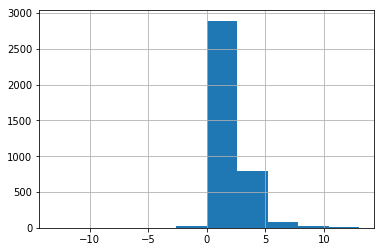

In [72]:
guests['diff'].hist();

There's at least one strange outlier. It seems the majority interpret "guests" to mean "additional person beyond yourself. But some seem to interpret as "total number of people staying." I think this means additional guests will typically incur a cost. I might create a "max occupancy covered by price" but it will require some assumptions.

In [77]:
# Explore min/max nights
listings[['minimum_nights', 'maximum_nights']].describe()

,minimum_nights,maximum_nights
count,3818.000000,3818.000000
mean,2.369303,780.447617
std,16.305902,1683.589007
min,1.000000,1.000000
25%,1.000000,60.000000
50%,2.000000,1125.000000
75%,2.000000,1125.000000
max,1000.000000,100000.000000


The majority have 1 or 2 minimum nights (no listings have 0). At least one listing has a maximum of 1. Most places seem to not really have a max, as they are listing values that are equivalent of 3 years+. 

In [78]:
# Explore calendar updated
listings.calendar_updated.unique()

array(['4 weeks ago', 'today', '5 weeks ago', '6 months ago',
       '7 weeks ago', '2 weeks ago', 'yesterday', '5 months ago',
       'a week ago', '5 days ago', '3 days ago', '2 months ago',
       '3 months ago', '4 days ago', '2 days ago', '3 weeks ago',
       '1 week ago', '13 months ago', '6 weeks ago', '8 months ago',
       '12 months ago', '4 months ago', 'never', '6 days ago',
       '10 months ago', '14 months ago', '9 months ago', '7 months ago',
       '30 months ago', '11 months ago', '22 months ago', '16 months ago',
       '15 months ago', '17 months ago'], dtype=object)

These could be converted to numerical values (equivalent days) if used to not require dummy variables. 

In [81]:
# Check if variation in has_availability
assert listings.has_availability.nunique() == 1

All listings have availability, can drop this column.

In [83]:
# Check if scrape date and calendar scrape date are the same
assert (listings.last_scraped == listings.calendar_last_scraped).sum() == listings.shape[0]

These are the same, can be dropped.

In [86]:
# Check if anyone requires license
listings.requires_license.value_counts()

f    3818
Name: requires_license, dtype: int64

No, can be dropped.

In [87]:
# Check if variation in jurisdiction
assert listings.jurisdiction_names.nunique() == 1

No, can be dropped

In [88]:
# Explore cancellation policies
print(listings.cancellation_policy.nunique())
listings.cancellation_policy.unique()

3


array(['moderate', 'strict', 'flexible'], dtype=object)

Three levels, easy to dummy.

In [90]:
# Check calculated_host_listings_count is the same as host_listings_count
(listings.calculated_host_listings_count == listings.host_listings_count).sum()

3189

For the most part (83.5% of the time), they do match. What is this second colum?

In [91]:
listings[['calculated_host_listings_count', 'host_listings_count']].head(10)

,calculated_host_listings_count,host_listings_count
0,2,3.0
1,6,6.0
2,2,2.0
3,1,1.0
4,1,2.0
5,1,1.0
6,1,1.0
7,5,5.0
8,1,1.0
9,6,6.0


It suggests that one of these is not accurate. Will need to do more work if going to determine which is accurate.

The dataset contains 92 columns and 3,818 rows of data. It looks as if this provides details for unique listings per row.

Details of the columns are as follows (data cleaning are in green, feature engineering in orange):
- **id**: Listing id, all unique, helpful for joining. <span style="color:green">Convert to str.</span>
- **listing_url**: The url for the listing of the form `https://www.airbnb.com/rooms/id`. <span style="color:green">Can be dropped.</span>
- **scrape_id**: The id of the data scrape by airbnb. <span style="color:green">Can be dropped.</span>
- **last_scraped**: The date of the scrape. <span style="color:green">Can be dropped.</span>
- **name**: Name selected by host for listing. <span style="color:orange">Could be useful for common term extraction.</span>
- **summary, space, description**: Text descriptions of the property provided by host. It appears that the information found in each of these can overlap. <span style="color:orange">Could be useful for common term extraction.</span>
- **experiences_offered**: All values are `none`. <span style="color:green">Can be dropped.</span>
- **neighborhood_overview**: Neighborhood description that looks to be provided by the host. Not always provided. 27% missing. <span style="color:orange">Could be useful for common term extraction.</span>
- **notes**: Additional information provided by the host. The information provided in this column can be quite variable. 42% missing. <span style="color:orange">Maybe just create missing dummy.</span>
- **transit**: Description of availability of public transport by host. 24% missing. <span style="color:orange">Text extraction likely quite helpful.</span>
- **thumbnail_url**: Link of the thumbnail image used for the listing. 8% missing. <span style="color:orange">Can create dummy for image present or not.</span>
- **medium_url**: Larger size of above. Same missing %. <span style="color:green">Can be dropped.</span>
- **picture_url**: Always has a picture url. What is the picture if thumbnail is missing? Otherwise, the same. <span style="color:green">Likely can be dropped.</span>
- **xl_picture_url**: Larger size of above. Same missing %. <span style="color:green">Can be dropped.</span>
- **host_id**: ID for the host, there are definitely hosts with multiple listings. <span style="color:green">Convert to str</span>
- **host_url**: url for host, same number as host_id. <span style="color:green">Can be dropped.</span>
- **host_name**: Seems just first name is typically used. Repeats because ppl have the same name. <span style="color:green">Can be dropped.</span>
- **host_since**: Date from when the host joined. <span style="color:green">Convert to unix date</span>
- **host_location**: Info provided by hosts. Typically of city, state, country format, but not consistent. 8 missing. <span style="color:orange">Needs cleaning to be interpretable.</span>
- **host_about**: Description provided by host. My contain location and employment/hobbies info. 22% missing. <span style="color:orange">Could be useful for common term extraction.</span>
- **host_response_time**: Ordinal categorization of response time with four levels. 14% missing. <span style="color:orange">Creat dummies.</span>
- **host_response_rate**: Percentage of whether they respond. 14% missing. <span style="color:green">Drop % and convert to int.</span>
- **host_acceptance_rate**: Almost all 100% (One 0%). 20% missing - does this mean no one has applied? <span style="color:orange">Can dummy for missing.</span>
- **host_is_superhost**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **host_thumbnail_url**: Url of host pic thumbnail. <span style="color:green">Can be dropped.</span>
- **host_picture_url**: Large version of above. <span style="color:green">Can be dropped.</span>
- **host_neighbourhood**: Seems to represent host location but distinct values. Can be in Seattle but can be elsewhere. 102 values. 8% missing. <span style="color:orange">Need to be combined with state/country for accurate location info.</span>
- **host_listings_count**: Seems to be number of listings per host. Only two missing. <span style="color:green">Double check data accuracy.</span>
- **host_total_listings_count**: Seems no different than above. <span style="color:green">Can be dropped.</span>
- **host_verifications**: List of methods(?) that host has been verified. <span style="color:green">Need to extract values if using.</span>
- **host_has_profile_pic**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **host_identity_verified**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **street**: Provides street, city, state abbr, zip code and country info for listing. <span style="color:green">Likely drop. Maybe extract missing zipcodes.</span>
- **neighbourhood**: <span style="color:green">Can be dropped because of below.</span>
- **neighbourhood_cleansed**: Provides neighbourhood details for the listing. <span style="color:orange">Maybe convert to dummy.</span>
- **neighbourhood_group_cleansed**: Provides wider grouping of listing location. <span style="color:orange">Maybe convert to dummy.</span>
- **city**: All values are the equivalent of Seattle <span style="color:green">Can be dropped.</span>
- **state**: All values are the equivalent of Washington <span style="color:green">Can be dropped.</span>
- **zipcode**: Zipcode of listing. <span style="color:green">Attempt to use `street` to extract missing values.</span>
- **market**: <span style="color:green">Can be dropped.</span>
- **smart_location**: All equivalent of Seattle. <span style="color:green">Can be dropped.</span>
- **country_code**: <span style="color:green">Can be dropped.</span>
- **country**: <span style="color:green">Can be dropped.</span>
- **latitude, longitude**: Coordinates for listing
- **is_location_exact**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **property_type**: Selection of property types. <span style="color:orange">Convert to dummies.</span>
- **room_type**: Three levels, entire, private, shared. <span style="color:orange">Convert to dummies.</span>
- **accommodates**: Max number of ppl able to be accommodated.
- **bathrooms**: Number of bathrooms in listing. >1% missing <span style="color:green">May drop missing.</span>
- **bedrooms**: Number of bedrooms in listing. >1% missing <span style="color:green">May drop missing.</span>
- **beds**: Number of beds in listing. 1 missing <span style="color:green">May drop missing.</span>
- **bed_type**: Five levels of bed type. <span style="color:orange">Convert to dummies.</span>
- **amenities**: List of available amenities. <span style="color:green">Need to extract values and manage entries that are null.</span>
- **square_feet**: Size of listing. 97% Missing. <span style="color:orange">Maybe dummy for missing.</span>
- **price**: Price of listing (at time of scrape?) <span style="color:green">Maybe drop because of calendar price.</span>
- **weekly_price**: Price per week (if available) <span style="color:green">Convert to numerical if using.</span>
- **monthly_price**: Price per month (if available) <span style="color:green">Convert to numerical if using.</span>
- **security_price**: Value of security deposit, if required. <span style="color:green">Create dummy for missing; convert to numerical.</span>
- **cleaning_fee**: Value of cleaning fee, if required. <span style="color:green">Create dummy for missing; convert to numerical.</span>
- **guests_included**: <span style="color:orange">Create "max accommodation included in price" column.</span>
- **extra_people**: Cost per extra person. <span style="color:green">Convert to numerical.</span>
- **minimum/maximum_nights**: <span style="color:green">May need to manage values over a year/maximum days available.</span>
- **calendar_update**: String of last time updated (I'm assuming compared to scrape day). <span style="color:green">Convert to days equivalent if using.</span>
- **has_availability**: All have availabilities. <span style="color:green">Can be dropped.</span>
- **availability_30/60/90/365**: Number of days listed as available in the interval (assuming from scrape date). <span style="color:green">Need to compare counts to listings.</span>
- **calendar_last_scraped**: <span style="color:green">Can be dropped.</span>
- **number_of_reviews**: Number of reviews received by host.
- **first/last_review**: Date of first/last review, not sure why some missing. <span style="color:green">Convert to date.</span>
- **review_scores_rating**: Some central measure of all ratings from 0 to 100. <span style="color:orange">May dummy missing.</span>
- **review_scores_accuracy/cleanliness/checkin/location/value**: Some central measure of the rating from 1 (low) to 10 (high) on the characteristic described. <span style="color:orange">May dummy missing.</span>
- **requires_license**: <span style="color:green">Can be dropped.</span>
- **license**: All null. <span style="color:green">Can be dropped.</span>
- **jurisdiction_names**: <span style="color:green">Can be dropped.</span>
- **instant_bookable**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **cancellation_policy**: Three levels. <span style="color:orange">Convert to dummies.</span>
- **require_guest_profile_picture/phone_verification**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **calculated_host_listings_count**: <span style="color:green">Needs further investigation to use.</span>
- **reviews_per_month**: As described. Same amount missing as first/last review. <span style="color:orange">May dummy missing.</span>

<a id="reviews"></a>
### 3.3. Reviews

In [92]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


This dataset contains information about reviews given by guests.

In [93]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


The dataset contains six columns and almost 85K rows of data.

#### Data Issues Identified
- **listing_id, id, reviewer_id**: <span style="color:green">convert to `str`</span>
- **date**: <span style="color:green"> convert to `datetime`</span>

The only feature with missing values is `comments`. It appears a small amount of people give some kind of review without leaving comments.

I'm not sure if I'm going to use this data. I could do some sentiment analysis, or work out how often people are repeat users of airbnb (based on those who comment), or at the same place. 

<a id='business'></a>
## 4. Business Understanding
After reviewing the available data, I decided that a potentially interesting approach would be to determine what features are associated with a host making a listing available, and whether it is possible to create a model that can predict whether a listing will be available. 

The scenario that I am wishing to address goes something like this:

_You stayed at a great airbnb location for your last vacation. You are thinking of going away in a few months, what is the likelihood that the host will have listed the place as available?_

Alternatively:

_You are scrolling through the airbnb site looking at different sites without having selected a date. Is there information that you use from this front page that may indicate that it is more likely that the host has listed the site as available for the dates you have in mind?_

It's important to note that with the information available, we don't have details of whether the available space was used, or how far in advance it was booked. So it's not possible to use this information to guarantee that the listing will be available when it's looked up, just that the host has made it avaialable. Hopefully, if people are searching far enough in advance, this is less of an issue.

One of the key elements of these questions is that the information that we are talking about needs to be salient to the users of the site. If a particular element is identified as having high importance in prediction but is not easily avaialable to someone viewing the site, this would be less helpful information. 

As a result, it's important to understand what information is available to people when viewing the listings. This is what the front page of homes looks like after searching for Seattle, WA.

![home_page](front_page.png)

There is an option at the bottom of this preview of listings to see all. Clicking on this link shows the following view:

![details](detail_page.png)

Based on these images, information that is quickly available when viewing the site includes:
- The property type
- Whether the room type
- The number of beds
- The name of the listing
- The cost per night
- The rating for the host (out of six stars)
- The number of ratings received
- Whether they are considered a superhost
- With the map on the side, it's also possible to use location based searches
- Whether cancellation is free

For someone who has stayed at the listing and is thinking of returning, other known information could include:
- Number of bedrooms and bathrooms
- Some of the available amenities
- The location

As a result, if any of these features are helpful in predicting avaiability, they would be considered very useful.

One element that is shown on the current site is a `Plus` indicator. Based on [information on the site](https://www.airbnb.ca/plus) this indicates very high quality listings, both in terms of the place to stay, and the host. However, this appears to be a new element of airbnb. As a result, it likely is not captured in the 2016 information available to us. 

<a id='data'></a>
## 5. Data Understanding

With an understanding of the business needs, it is also possible to make some further determinations about what information is appropriate to include as potential features for our model.

<a id="listing"></a>
### 5.1. Listing Information
For example, based on these details, I am going to include some term extraction for the listing name, but will exclude any analysis of 
- summary
- space
- description 
- neighborhood_overview
- notes 
These are fields in which the information will not be easily avaible to the potential guests of our imagined scenarios. This reduces the amount of text extraction needed and also the number of potential dummy variables.

The framing of the business case also suggests that the following fields can be excluded because they are either not easily available in the imagined scenario, their interpretation is challenging, or they potentially add limited information.
- guests_included
- calendar_update
- first/last_review
- reviews_per_month
- square_feet

While transit seems like relevant information, it's not data that is clearly available on the current navigation screen of the site, so I will only include this field as a dummy representing a discussion of transport or not. 

<a id="host"></a>
### 5.2. Host Information
I'll also drop some of the host information that would not be easily available in our imagined scenarios:
- host_location
- host_about
- host_neighbourhood
- host_verifications
- host_acceptance_rate

While this information is not available in our scenarios, I'm including it to see if there is any relevance:
- host_response_time
- host_response_rate
- host_listings_count
- host_has_profile_pic
- host_identity_verified

I'll also definitely be including whether the host is a superhost.

<a id="review"></a>
### 5.3. Review Information
Because of the business case proposed, I'm going to exclude any analysis of the reviews. 

<a id="date"></a>
### 5.4. Date Information
One of the key elements of this data is date information. Common key features to consider when analyzing date information (References: [1](https://datascience.stackexchange.com/questions/2368/machine-learning-features-engineering-from-date-time-data), [2](https://www.salford-systems.com/blog/dan-steinberg/using-dates-in-data-mining-models)) can include what day of the week it is, the season of the year, and whether special events are occurring. These all seem relevant to the current business case. 

As a result, I plan to create dummy variables for the day of the week and season based on calendar dates. I will also identify key vacation periods that might be relevant to when people would typically look for accommodation. Once these are done, I will exclude the actual dates. 

There is also a date field of `host_since`. This is best understood as a measure of recency. As a result, I will be converting this to a unix representation of date to provide clear intervals between dates.

<a id='prep'></a>
## 6. Data Preparation

<a id="clean"></a>
### 6.1. Cleaning

In [61]:
# Make copies of the initial datasets
df_cal = calendar.copy()
df_list = listings.copy()

<a id='zipcode'></a>
#### 6.1.1. Missing zipcodes
Determine if missing values in `zipcode` can be extracted from `street`. If so, replace `zipcode` with `.str.split(',')[-2]` from `street`.

In [4]:
# Compare missing for each field
(df_list.zipcode.isna() == df_list.street.isna()).sum()

3811

The majority are the same but some are different, it may be possible to extract.

In [5]:
# Investigate street info for missing zipcodes
df_list[['zipcode', 'street']][df_list.zipcode.isna()]

,zipcode,street
162,NaN,"Seattle, WA, United States"
479,NaN,"14th Avenue West, Seattle, WA, United States"
988,NaN,"-30th. Ave., Seattle, WA, United States"
1672,NaN,"Seattle, WA, United States"
1917,NaN,"Seattle, WA, United States"
2521,NaN,"Harvard Avenue East, Seattle, WA, United States"
2671,NaN,"Seattle, WA, United States"


When zipcode information is missing, it is not included in the street details, therefore these values cannot be replaced. 

<a id="join"></a>
#### 6.1.2. Join datasets
Combine two datasets towards creating a tidy master using `pd.merge()` with a left join on `df_cal`. Drop `listing_id` once merged.

In [62]:
df = pd.merge(df_cal, df_list, how='left', left_on='listing_id', right_on='id')
df.drop('listing_id', axis=1, inplace=True)

In [7]:
df.head()

,date,available,price_x,id,listing_url,scrape_id,last_scraped,name,summary,space,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2016-01-04,t,$85.00,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,2016-01-05,t,$85.00,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
2,2016-01-06,f,NaN,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
3,2016-01-07,f,NaN,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
4,2016-01-08,f,NaN,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [63]:
# Test: confirm columns and rows are correct
assert df.shape[1] == (df_cal.shape[1] + df_list.shape[1] - 1)
assert df.shape[0] == df_cal.shape[0]

<a id="unnecessary"></a>
#### 6.1.3. Drop unnecessary columns
Create list based on assessment and business case. The merge resulted in two price columns. Need to drop `price_y` and convert `price_x` to `price`.

In [64]:
drop_cols = ['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 
             'neighborhood_overview', 'notes', 'medium_url', 'picture_url', 
             'xl_picture_url', 'host_url', 'host_name', 'host_location', 
             'host_about', 'host_thumbnail_url', 'host_picture_url', 
             'host_neighbourhood', 'host_total_listings_count', 
             'host_verifications', 'street', 'neighbourhood', 'city', 'state', 
             'market', 'smart_location', 'country_code', 'country', 'price_y',
             'weekly_price', 'monthly_price', 'guests_included', 
             'calendar_updated', 'has_availability', 'calendar_last_scraped', 
             'first_review', 'last_review', 'requires_license', 'license', 
             'jurisdiction_names', 'reviews_per_month', 'square_feet']

df_drop_cols = df.drop(drop_cols, axis=1)

In [65]:
df_drop_cols.rename(columns={'price_x': 'price'}, inplace=True)

In [66]:
# Test: Confirm correct column number
assert df_drop_cols.shape[1] == df.shape[1] - len(drop_cols)
# Test: Confirm presence of price in columns
assert 'price' in df_drop_cols.columns

<a id="rows"></a>
#### 6.1.4. Drop specified rows with missing values
Columns that have missing values where rows will be dropped are:
- bathrooms
- bedrooms
- beds
- host_is_superhost

In [67]:
drop_rows = ['bathrooms', 'bedrooms', 'beds', 'host_is_superhost']
df_drop_rowcol = df_drop_cols.dropna(subset=drop_rows)

In [68]:
# Test: Confirm correct row count
assert df_drop_cols.shape[0] - df_drop_rowcol.shape[0] \
       == (df_drop_cols[drop_rows].isna().sum(axis=1) > 0).sum()

<a id="str"></a>
#### 6.1.5. Convert columns to `str`
Create a copy of the df and then convert relevant columns to `str`. The columns that need to be converted to `str` are:
- id
- host_id

In [69]:
df_convert_str = df_drop_rowcol.copy()
str_cols = ['id', 'host_id']
df_convert_str.loc[:, str_cols] = df_convert_str[str_cols].astype(str)

In [70]:
# Test: Confirm two more object columns
assert (df_drop_rowcol.dtypes == object).sum() \
       == ((df_convert_str.dtypes == object).sum() - len(str_cols))

<a id="bool"></a>
#### 6.1.6. Convert columns to `1`, `0`
Create new copy of df. Convert columns correctly coded with `t` and `f` to `1` and `0` respectively. Columns that need to be converted are:
- available
- host_is_superhost
- host_has_profile_pic
- host_identity_verified
- is_location_exact
- instant_bookable
- require_guest_profile_picture
- require_guest_phone_verification

Double check that there is variations in the value counts before converting. If no variation, then drop.

In [71]:
bool_cols = ['available', 'host_is_superhost', 'host_has_profile_pic', 
             'host_identity_verified', 'is_location_exact', 'instant_bookable', 
             'require_guest_profile_picture', 'require_guest_phone_verification']

for col in bool_cols:
    print('\n')
    print(col)
    print(df_convert_str[col].value_counts())



available
t    927644
f    457166
Name: available, dtype: int64


host_is_superhost
f    1100840
t     283970
Name: host_is_superhost, dtype: int64


host_has_profile_pic
t    1382255
f       2555
Name: host_has_profile_pic, dtype: int64


host_identity_verified
t    1087335
f     297475
Name: host_identity_verified, dtype: int64


is_location_exact
t    1237350
f     147460
Name: is_location_exact, dtype: int64


instant_bookable
f    1170555
t     214255
Name: instant_bookable, dtype: int64


require_guest_profile_picture
f    1269105
t     115705
Name: require_guest_profile_picture, dtype: int64


require_guest_phone_verification
f    1249395
t     135415
Name: require_guest_phone_verification, dtype: int64


Each has values for both levels, so convert all.

In [72]:
df_str_bool = df_convert_str.copy()
df_str_bool.loc[:, bool_cols] = df_str_bool[bool_cols].replace({'t': 1, 'f': 0})

In [73]:
# Test: Confirm more int columns
assert (df_str_bool.dtypes == 'int64').sum() \
       == ((df_convert_str.dtypes == 'int64').sum() + len(bool_cols))

<a id="price"></a>
#### 6.1.7. Convert price/percent columns to `float`
Copy df. Use `.str.strip()` to replace `\$` and `%`. Use `.str.replace(',','')` to manage commas in values. Then convert to `float`. Columns that need to be converted are:
- host_response_rate (%)
- security_deposit (\$)
- cleaning_fee (\$)
- extra_people (\$)
- price (\$)

In [74]:
df_str_bool_flt = df_str_bool.copy()
num_cols = ['host_response_rate', 'security_deposit', 'cleaning_fee', 
            'extra_people', 'price']

# Make the replacements
for col in num_cols:
    df_str_bool_flt.loc[:, col] = df_str_bool_flt[col].str.strip('%$').str.replace(",", "").astype(float)

In [75]:
# Test: Confirm more float columns
assert (df_str_bool_flt.dtypes == 'float64').sum() \
       == ((df_str_bool.dtypes == 'float64').sum() + len(num_cols))

<a id="datetime"></a>
#### 6.1.8. Convert columns to `datetime`
Copy df. Convert columns to date. Relevant columns are:
- host_since
- date

In [76]:
df_dtypes = df_str_bool_flt.copy()
date_cols = ['host_since', 'date']

for col in date_cols:
    df_dtypes.loc[:, col] = pd.to_datetime(df_dtypes[col])

In [77]:
df_dtypes[date_cols].dtypes

host_since    datetime64[ns]
date          datetime64[ns]
dtype: object

In [78]:
# Test: Confirm more datetime columns
assert (df_dtypes.dtypes == 'datetime64[ns]').sum() \
       == ((df_str_bool_flt.dtypes == 'datetime64[ns]').sum() + len(date_cols))

<a id="unix"></a>
#### 6.1.9. Convert `host_since` to unix time
Convert to type `np.int64`.

In [79]:
df_dtypes.host_since = df_dtypes.host_since.astype(np.int64)

In [80]:
# Test: Confirm 1 more int64 column
assert (df_dtypes.dtypes == 'int64').sum() \
       == ((df_str_bool_flt.dtypes == 'int64').sum() + 1)

<a id="amen"></a>
#### 6.1.10. Extract amenities

1. Confirm that all missing info is represented by `{}`. 
1. Make a copy of the df.
2. Strip remaining `{}`.
3. Replace " with empty string. 
4. Create a new amenities df with `.str.split(',', expand=True)`.
5. Determine the set of unique values.
6. Create dummy variables for amenities using unique amenity values as column names and `.str.contains(amenity)` to create bool values.
6. Drop the amenities column. 

In [81]:
# Check value counts
df_dtypes.amenities.value_counts()[:5]

{}                                                                                                                                                                                                                                                                                                                                                                                         14965
{Internet,"Wireless Internet",Kitchen,"Free Parking on Premises",Heating,Washer,Dryer}                                                                                                                                                                                                                                                                                                      4015
{TV,"Cable TV",Internet,"Wireless Internet",Pool,Kitchen,"Free Parking on Premises",Gym,"Elevator in Building","Hot Tub",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Es

In [82]:
df_clean_amen = df_dtypes.copy()

In [83]:
# Clean text
df_clean_amen.amenities = df_clean_amen.amenities.str.strip('{}').str.replace('"', '')

# Extract unique values
df_amenities = df_clean_amen.amenities.str.split(',', expand=True)
amenities = pd.unique(df_amenities.values.ravel('K'))

In [84]:
amenities

array(['TV', 'Internet', 'Wireless Internet', 'Cable TV',
       'Air Conditioning', '', 'Kitchen', 'Elevator in Building',
       'Wheelchair Accessible', 'Smoke Detector',
       'Free Parking on Premises', 'Pool', 'Pets live on this property',
       None, 'Breakfast', 'Gym', 'Heating', 'Washer',
       'Buzzer/Wireless Intercom', 'Smoking Allowed',
       'Carbon Monoxide Detector', 'Pets Allowed', 'Indoor Fireplace',
       'Dryer', 'Dog(s)', 'Family/Kid Friendly', 'Hot Tub', 'Cat(s)',
       'Essentials', 'Shampoo', 'First Aid Kit', 'Doorman',
       'Fire Extinguisher', 'Safety Card', 'Washer / Dryer',
       'Suitable for Events', 'Other pet(s)', 'Hangers',
       '24-Hour Check-in', 'Laptop Friendly Workspace',
       'Lock on Bedroom Door', 'Hair Dryer', 'Iron'], dtype=object)

There is `None` in the list which will likely create an exception, so need to manage that. 

In [85]:
for amenity in amenities:
    try:
        df_clean_amen[amenity] = df_clean_amen.amenities.str.contains(amenity)
    except:
        continue

C:\Users\rebecca-barnes\Anaconda3\envs\dand\lib\site-packages\ipykernel\__main__.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


In [86]:
# Drop original amenities
df_clean_amen.drop('amenities', axis=1, inplace=True)

In [87]:
# Test: Correct number of new columns
assert df_clean_amen.shape[1] == df_dtypes.shape[1] + len(amenities) - 2
# Test: Confirm correct datatype
assert (df_clean_amen.loc[:, 'TV':].dtypes == bool).sum() == len(amenities) - 1

<a id="remain"></a>
#### 6.1.11. Manage remaining columns

In reviewing the work needed for the remaining columns that were identified as neededing cleaning:
- host_listings_count
- minimum_nights
- maximum_nights
- availability_30
- availability_60
- availability_90
- availability_365
- calculated_host_listings_count
- summary
- space
- description
- transit
- host_response_rate
- host_acceptance_rate

Upon further consideration, I decided that given that this information was not immediately available in the imagined business case that I would drop these columns.

In [88]:
drop_cols = ['host_listings_count', 'minimum_nights', 'maximum_nights', 
             'availability_30', 'availability_60', 'availability_90', 
             'availability_365', 'calculated_host_listings_count', 
             'summary', 'space', 'description', 'transit', 
             'host_acceptance_rate', 'host_response_rate', 'is_location_exact']

df_clean = df_clean_amen.drop(drop_cols, axis=1)

In [89]:
# Test: Columns have been dropped
assert df_clean.shape[1] == df_clean_amen.shape[1] - len(drop_cols)

In [90]:
# Save cleaned df
df_clean.to_csv('data/data_clean.csv', index=False)

This concludes the data cleaning. It is now time to move on to feature engineering.

<a id="engineer"></a>
### 6.2. Feature Engineering

<a id="split"></a>
#### 6.2.1. Train-Test split

Because some of the next steps will involve imputing values and other preprocessing, it is time to split the data into train and test sets. Before splitting, I want to check the imbalance of the response data. 

In [27]:
# Designate dtypes to prevent mixed types
dtype={"date": str, "available": int, "price": float, "id": str, "name": str, 
       "thumbnail_url": str, "host_id": str, "host_since": int, 
       "host_response_time": str, "host_is_superhost": int, 
       "host_has_profile_pic": int, "host_identity_verified": int, 
       "neighbourhood_cleansed": str, "neighbourhood_group_cleansed": str,
       "zipcode": str, "latitude": float, "longitude": float, 
       "property_type": str, "room_type": str, "accommodates": int, 
       "bathrooms": float, "bedrooms": float, "beds": float, "bed_type": str,
       "security_deposit": float, "cleaning_fee": float, "extra_people": float,
       "number_of_reviews": int, "review_scores_rating": float, 
       "review_scores_accuracy": float, "review_scoares_cleanliness": float,
       "review_scores_checkin": float, "review_scores_communication": float,
       "review_scores_location": float, "review_scores_value": float, 
       "instant_bookable": int, "cancellation_policy": str, 
       "require_guest_profile_picture": int, 
       "require_guest_phone_verification": int}

In [37]:
df_clean = pd.read_csv('data/data_clean.csv', dtype=dtype, 
                       date_parser=pd.to_datetime, parse_dates=['date'])

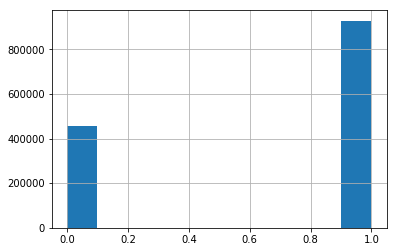

In [91]:
# Split into signals and response
y = df_clean['available']
X = df_clean.drop('available', axis=1)

# Explore balance of response
y.hist();

There is some imbalance, with approximately double the number of dates with availability compared to those without. As a result, it is helpful to manage this when splitting. 

It is also my intention to create a train, validation, and final test set with splitting.

In [92]:
# Implement train-test split with 10% as test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Implement train-validation split with 20% as validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [93]:
# Save datasets
files = [X_train, y_train, X_valid, y_valid, X_test, y_test]
names = ['X_train', 'y_train', 'X_valid', 'y_valid', 'X_test', 'y_test']
folder = 'data'

for file, name in zip(files, names):
    file.to_csv(os.path.join(folder, name + '.csv'), index=False)
    print(name, ":", file.shape)

X_train : (997063, 80)
y_train : (997063,)
X_valid : (249266, 80)
y_valid : (249266,)
X_test : (138481, 80)
y_test : (138481,)


There are now 997k rows in the training set, 249k rows in the validation set and 138k rows in the testing set.

<a id="skew"></a>
#### 6.2.2. Review distribution skew

In [4]:
dtype={"date": str, "available": int, "price": float, "id": str, "name": str, 
       "thumbnail_url": str, "host_id": str, "host_since": int, 
       "host_response_time": str, "host_is_superhost": int, 
       "host_has_profile_pic": int, "host_identity_verified": int, 
       "neighbourhood_cleansed": str, "neighbourhood_group_cleansed": str,
       "zipcode": str, "latitude": float, "longitude": float, 
       "property_type": str, "room_type": str, "accommodates": int, 
       "bathrooms": float, "bedrooms": float, "beds": float, "bed_type": str,
       "security_deposit": float, "cleaning_fee": float, "extra_people": float,
       "number_of_reviews": int, "review_scores_rating": float, 
       "review_scores_accuracy": float, "review_scoares_cleanliness": float,
       "review_scores_checkin": float, "review_scores_communication": float,
       "review_scores_location": float, "review_scores_value": float, 
       "instant_bookable": int, "cancellation_policy": str, 
       "require_guest_profile_picture": int, 
       "require_guest_phone_verification": int}

X_train = pd.read_csv('data/X_train.csv', dtype=dtype, 
                       date_parser=pd.to_datetime, parse_dates=['date'])

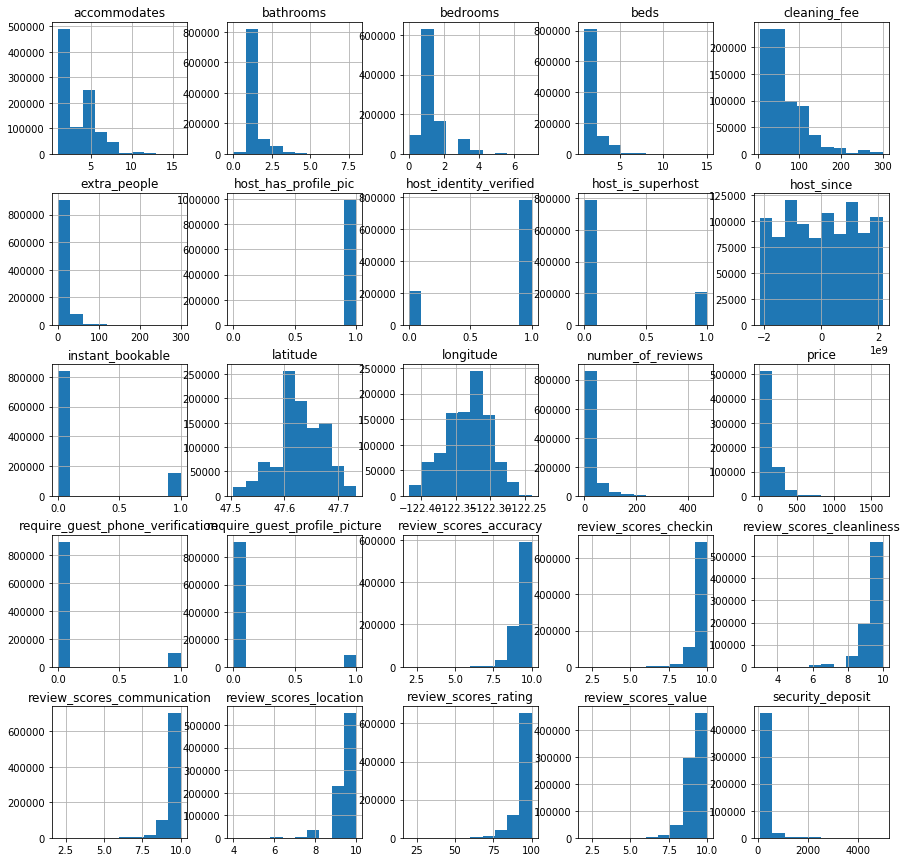

In [11]:
# Exclude bools
non_bool_col = X_train.dtypes[X_train.dtypes != bool].index

# Plot hist of distributions
X_train[non_bool_col].hist(figsize=(15, 15));

In [14]:
skew_scores = X_train.skew()
skew_scores[np.abs(skew_scores) > 2]

price                                3.211449
host_has_profile_pic               -23.056923
bathrooms                            2.934471
beds                                 2.466683
security_deposit                     5.862173
extra_people                         5.175080
number_of_reviews                    4.101450
review_scores_rating                -2.943299
review_scores_accuracy              -3.219255
review_scores_cleanliness           -2.557452
review_scores_checkin               -4.994668
review_scores_communication         -5.590270
review_scores_value                 -2.088230
require_guest_profile_picture        3.006771
require_guest_phone_verification     2.708494
Internet                            -5.338901
Wireless Internet                   -4.803930
Kitchen                             -2.637127
Wheelchair Accessible                3.159775
Smoke Detector                      -2.098939
Pool                                 4.611192
Breakfast                         

Many of features are highly skewed (|skew| above 2) and would benefit from log transformation. However, I'll only be transforming non-binary values. ([Reference](http://www.talkstats.com/threads/log-transformation-of-binary-variables.19623/))

In [15]:
skewed = ['price', 'bathrooms', 'beds', 'security_deposit', 'extra_people', 
          'review_scores_rating', 'review_scores_accuracy', 
          'review_scores_cleanliness', 'review_scores_checkin', 
          'review_scores_communication', 'review_scores_value']

X_log_trans = X_train.copy()
X_log_trans.loc[:, skewed] = X_log_trans[skewed].apply(lambda x: np.log(x + 0.1))

Let's also do a quick check of the distribution of dates.

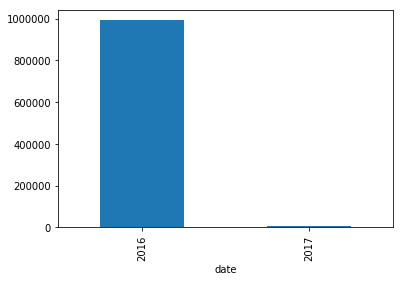

In [25]:
# Groupby year
X_log_trans["date"].groupby(X_log_trans["date"].dt.year).count()\
.plot(kind="bar", color="#1f77b4");

In [20]:
X_log_trans["date"].groupby(X_log_trans["date"].dt.year).count()

date
2016    991544
2017      5519
Name: date, dtype: int64

There are some values in 2017, so this may affect the values for January and February.

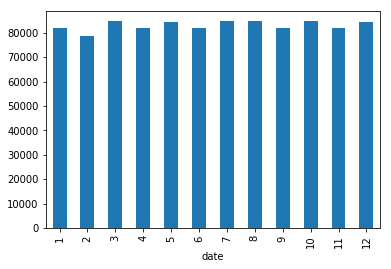

In [26]:
# Group by month
X_log_trans["date"].groupby(X_log_trans["date"].dt.month).count()\
.plot(kind="bar", color="#1f77b4");

In [27]:
X_log_trans["date"].groupby(X_log_trans["date"].dt.month).count()

date
1     81937
2     78916
3     84786
4     81822
5     84551
6     81950
7     84801
8     84880
9     82091
10    84843
11    82001
12    84485
Name: date, dtype: int64

In [28]:
X_log_trans["date"].value_counts().sort_index()

2016-01-04    2714
2016-01-05    2733
2016-01-06    2736
2016-01-07    2702
2016-01-08    2754
2016-01-09    2756
2016-01-10    2720
2016-01-11    2768
2016-01-12    2717
2016-01-13    2714
2016-01-14    2722
2016-01-15    2737
2016-01-16    2725
2016-01-17    2759
2016-01-18    2689
2016-01-19    2725
2016-01-20    2726
2016-01-21    2718
2016-01-22    2732
2016-01-23    2682
2016-01-24    2727
2016-01-25    2736
2016-01-26    2769
2016-01-27    2700
2016-01-28    2719
2016-01-29    2735
2016-01-30    2719
2016-01-31    2784
2016-02-01    2745
2016-02-02    2733
              ... 
2016-12-04    2730
2016-12-05    2717
2016-12-06    2684
2016-12-07    2743
2016-12-08    2749
2016-12-09    2697
2016-12-10    2755
2016-12-11    2714
2016-12-12    2690
2016-12-13    2745
2016-12-14    2724
2016-12-15    2748
2016-12-16    2779
2016-12-17    2753
2016-12-18    2704
2016-12-19    2706
2016-12-20    2712
2016-12-21    2717
2016-12-22    2748
2016-12-23    2730
2016-12-24    2735
2016-12-25  

In [31]:
X_log_trans["date"].value_counts().describe()

count     365.000000
mean     2731.679452
std        25.259613
min      2664.000000
25%      2714.000000
50%      2732.000000
75%      2749.000000
max      2808.000000
Name: date, dtype: float64

The number of listings per day is relatively consistent with a mean of 2732 and a standard deviation of only 25. Therefore there's no reason to be concerned about strange date distributions impacting results.

<a id="cat"></a>
#### 6.2.3. Convert categorical columns to dummies
Relevant columns are:
- host_response_time
- neighbourhood_cleansed
- neighbourhood_group_cleansed
- property_type
- room_type
- bed_type
- cancellation_policy

Solution:
1. Create copy of df. 
2. Create df for dummies. 
3. Merge back on index.
4. Drop original columns.

In [32]:
X_cat_dummies = X_log_trans.copy()

cat_cols = ['host_response_time', 'neighbourhood_cleansed', 
            'neighbourhood_group_cleansed', 'property_type', 'room_type', 
            'bed_type', 'cancellation_policy']

# Create dummies
df_cat_cols = pd.get_dummies(X_cat_dummies[cat_cols], dummy_na=True)
# Join back on
X_cat_dummies = pd.merge(X_cat_dummies, df_cat_cols, 
                          left_index=True, right_index=True)
# Drop cols
X_cat_dummies.drop(cat_cols, axis=1, inplace=True)

<a id="date-feat"></a>
#### 6.2.4. Create date dummies
As stated previously, there are three types of date dummy variables I would like to create - day of the week, season, and holiday dates.

Solution:
1. Create a copy of the df
2. Day of the week: Create a new column with `.dt.dayofweek`
3. Define dates for each season, create bool column for each 
4. Define dates for each holiday, create bool column for each 

In [33]:
X_date_dummies = X_cat_dummies.copy()

# Create weekday column
X_date_dummies['weekday'] = X_date_dummies.date.dt.dayofweek
# Test: seven unique values
assert X_date_dummies.weekday.nunique() == 7
# Test: range from 0 to 6
assert (X_date_dummies.weekday.min() == 0) & (X_date_dummies.weekday.max() == 6)

In [34]:
# Define seasons (end is before second date)
summer = ('2016-06-20', '2016-09-22')
fall = ('2016-09-22', '2016-12-21')
winter_end_of_year = ('2016-12-21', '2017-03-20')
winter_start_of_year = ('2016-01-01', '2016-03-19')
spring = ('2016-03-19', '2016-06-20')

# Create list of seasons and names
seasons = [summer, fall, spring]
names = ['summer', 'fall', 'spring']

# Create columns
for season, name in zip(seasons, names):
    X_date_dummies[name] = (season[0] <= X_date_dummies.date) & (X_date_dummies.date < season[1])

X_date_dummies['winter'] = ((winter_end_of_year[0] <= X_date_dummies.date) & (X_date_dummies.date < winter_end_of_year[1])) \
                           | ((winter_start_of_year[0] <= X_date_dummies.date) & (X_date_dummies.date < winter_start_of_year[1]))

In [35]:
# Test: Sum of season columns should equal rows
assert X_date_dummies.loc[:, 'summer':'winter'].sum().sum() \
       == X_date_dummies.shape[0]

This [resource](https://www.officeholidays.com/countries/usa/regional.php?list_year=2016&list_region=Washington) was used to confirm holiday dates.

In [36]:
# Collect federal/state holidays
new_year = ['new_year', 'Friday', '2016-01-01']
mlk = ['mlk', 'Monday', '2016-01-16']
presidents = ['presidents', 'Monday', '2016-02-15']
memorial = ['memorial', 'Monday', '2016-05-30']
fourth_july = ['fourth_july', 'Monday', '2016-07-04']
labor = ['labor', 'Monday', '2016-09-05']
veteran = ['veteran', 'Friday', '2016-11-11']
thanksgiving = ['thanksgiving', 'Thursday', '2016-11-24']
christmas = ['christmas', 'Monday', '2016-12-26']

holidays = [new_year, mlk, presidents, memorial, fourth_july, labor, 
            veteran, thanksgiving, christmas]

# Define start and end for each holiday
for holiday in holidays:
    hol_date = datetime.strptime(holiday[2], '%Y-%m-%d')
    if holiday[1] == 'Monday':
        # Start date is the Friday before
        holiday.append(hol_date - timedelta(days=3))
        # End date is the day after
        holiday.append(hol_date + timedelta(days=1))
    if holiday[1] == 'Friday':
        # Start date is the day before
        holiday.append(hol_date - timedelta(days=1))
        # End date is the Monday after
        holiday.append(hol_date + timedelta(days=3))
    if holiday[1] == 'Thursday':
        # Start date is the day before
        holiday.append(hol_date - timedelta(days=1))
        # End date is the Monday after
        holiday.append(hol_date + timedelta(days=4))

# Create columns
for holiday in holidays:
    X_date_dummies[holiday[0]] = (holiday[-2] \
                                  <= X_date_dummies.date) \
                                 & (X_date_dummies.date < holiday[-1])

In [37]:
# Test: New # bool columns are the same as # holidays + seasons 
assert (X_date_dummies.dtypes == bool).sum() \
       == (X_cat_dummies.dtypes == bool).sum() + len(holidays) + 4

This [resource](https://www.seattleschools.org/UserFiles/Servers/Server_543/File/District/Departments/School%20Board/16-17agendas/05_17_2017/I01_20170517_Action_Report_2017-18_School_Calendar.pdf) was used to confirm school holidays:
- Winter Break: At least ten weekdays, ending after New Year’s Day. If New Year’s Day falls or is observed on a Monday, students will return to school on the next day (Tuesday).
- Mid-Winter Break: President’s Day and the following four workdays.
- Spring Break: Five days starting the second Monday in April.
- Summer Break: From last day of school (June 22) to first day of school (first Wed in Sep - 7th)

In [38]:
# Collect school holidays
winter_break = ['winter_break', '2016-12-19', '2017-01-02']
mid_winter_break = ['mid_winter_break', '2016-02-15', '2016-02-22']
spring_break = ['spring_break', '2016-04-11', '2016-04-18']
summer_break = ['summer_break', '2016-06-22', '2016-09-07']

school_hols = [winter_break, mid_winter_break, spring_break, summer_break]

# Create columns
for holiday in school_hols:
    X_date_dummies[holiday[0]] = (holiday[1] <= X_date_dummies.date) & (X_date_dummies.date < holiday[2])

In [39]:
# Test: New # bool columns are the same as # holidays + seasons + school_hols
assert (X_date_dummies.dtypes == bool).sum() \
       == (X_cat_dummies.dtypes == bool).sum() + len(school_hols) \
       + len(holidays) + 4
# Test: Review names of last added columns
X_date_dummies.columns[-(len(school_hols) + len(holidays) + 4):]

Index(['summer', 'fall', 'spring', 'winter', 'new_year', 'mlk', 'presidents',
       'memorial', 'fourth_july', 'labor', 'veteran', 'thanksgiving',
       'christmas', 'winter_break', 'mid_winter_break', 'spring_break',
       'summer_break'],
      dtype='object')

Now that dummies have been created for date, the exact dates are no longer needed.

In [40]:
X_date_dummies.drop('date', axis=1, inplace=True)

<a id="text"></a>
#### 6.2.5. Text extraction

I wanted to complete some text extraction from the name of the listing as that is available to site users on first views. However, I didn't want to add too many more features so I decided to limit it to the top 30.

In [41]:
X_text_count = X_date_dummies.copy()

# Instantiate the CountVectorizer method
count_vector = CountVectorizer(stop_words='english', max_features=30)

# Fit count_vector and get list of features
word_count = count_vector.fit_transform(X_text_count.name)
words = count_vector.get_feature_names()

# Convert word_count to df, inc. indication of name content
word_df = pd.DataFrame(word_count.todense(), index=X_text_count.index,
                       columns=['name_' + word for word in words])

# Merge with original df and drop 'name column'
X_text_count = pd.concat([X_text_count, word_df], axis=1)
X_text_count.drop('name', axis=1, inplace=True)

In [42]:
# Test: Confirm additional 30 with dropped column
assert X_text_count.shape[1] == X_date_dummies.shape[1] + len(words) - 1

For interest's sake I thought I'd check out the counts for the words.

In [52]:
word_df.sum()

name_anne          30892
name_apartment     76116
name_apt           54638
name_ballard       45957
name_bath          28775
name_bed           28982
name_bedroom       66857
name_capitol       78384
name_charming      35514
name_city          33226
name_cottage       27963
name_cozy          76100
name_downtown      72121
name_fremont       29806
name_hill         110688
name_home         101010
name_house         56433
name_lake          43827
name_location      34225
name_modern        76208
name_near          54868
name_private       92785
name_queen         38522
name_room         113343
name_seattle      143311
name_spacious      36294
name_studio        75545
name_suite         32523
name_uw            34949
name_view          75592
dtype: int64

<a id="missing"></a>
#### 6.2.6. Explore missing values
There are a number of columns with missing values. It is worth investigating whether these rows should be dropped, imputed, and/or dummy variables for missing created. 

The relevant columns are:
- security_deposit
- cleaning_fee
- review_scores_rating
- review_scores_accuracy
- review_scores_cleanliness
- review_scores_checkin
- review_scores_location
- review_scores_value

In [130]:
explore_cols = ['security_deposit', 'cleaning_fee', 'review_scores_rating', 
                'review_scores_accuracy', 'review_scores_cleanliness', 
                'review_scores_checkin', 'review_scores_location', 
                'review_scores_value']

In [131]:
X_text_count[explore_cols].describe()

,security_deposit,cleaning_fee,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_location,review_scores_value
count,488197.000000,728628.000000,828867.000000,825986.000000,827297.000000,825991.000000,826778.000000,826518.000000
mean,288.202234,61.753332,94.554994,9.636286,9.557713,9.788516,9.610486,9.454550
std,269.980288,48.937689,6.600425,0.699386,0.795069,0.591283,0.628974,0.749255
min,95.000000,5.000000,20.000000,2.000000,3.000000,2.000000,4.000000,2.000000
25%,150.000000,25.000000,93.000000,9.000000,9.000000,10.000000,9.000000,9.000000
50%,250.000000,50.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,350.000000,83.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,5000.000000,300.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000


For `security_deposit` and `cleaning_fee` all minimums are above 0. This suggests that when the value is missing, there is no cost for these features. Therefore missing values can be filled with 0.

How many missing values are there for the remaining columns?

In [132]:
X_text_count[explore_cols[2:]].isna().sum()

review_scores_rating         168196
review_scores_accuracy       171077
review_scores_cleanliness    169766
review_scores_checkin        171072
review_scores_location       170285
review_scores_value          170545
dtype: int64

What's interesting here is that the counts for the missing values are actually quite similar. Are there patterns in what is missing?

In [44]:
# What is the last column before the dummies?
df_clean.columns[-(len(amenities))]

'require_guest_phone_verification'

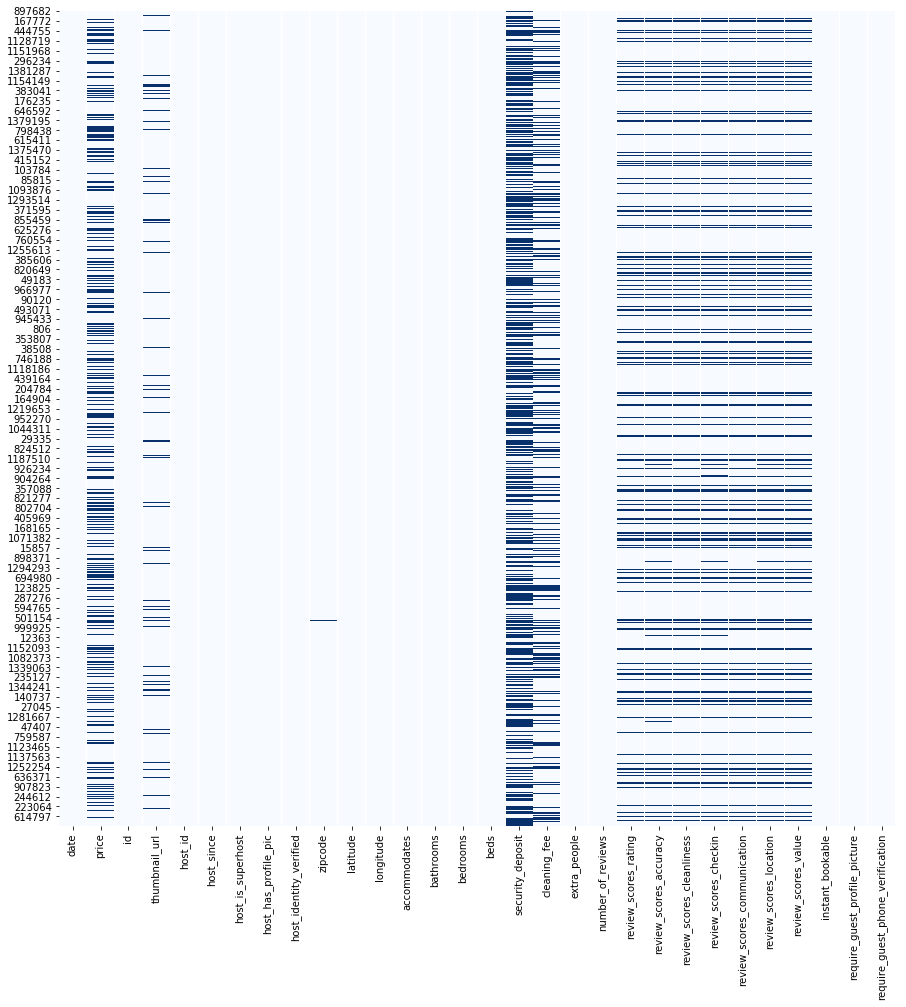

In [133]:
# Plot pattern of missing values - dark blue are missing
plt.figure(figsize=(15,15))
sns.heatmap(X_text_count.loc[:, :'require_guest_phone_verification'].isna(),\
            cmap='Blues', cbar=False); 

It is clear that when one rating is missing, it is very likely that other ratings are missing. There does not seem to be a clear relationship between the pattern of missing ratings and missing values in other areas. 

Other observations include the fact that most people do not require a security deposit. More than 50% also don't seem to require a cleaning fee, but more people require a cleaning fee than a security deposit. (This seems to make some sense as returning security deposits can be challenging to manage, but most visits do require cleaning)

There are only a small amount missing values in zipcode, but to use it effectively, I will need to dummy the zipcodes. I've got a lot of other location information so I'm just going to drop it.

The final decision to manage is what to do with the missing values for price and the ratings. 

Price is missing when the listing is not available. These could be filled with 0, but that would seem to create a distortion of the impact of price when predicting availability. It would also be possible to impute with the mean, but the mean across the board seems to generic. What seems reasonable is that while a listing may be unavailable, the effective price for that listing would be similar to that on days when it is available. It would seem that a KNN imputation would be quite helpful here. However, this also means that it would likely be helpful to dummy the categorical variables to assist in determining the nearest neighbors.

The variation in ratings is relatively small for each feature - the std is less than 10% of the maximum rating for each score. Therefore it may not be necessary to use KNN, although, this may just be covered in the above. I will also include a dummy variable for missing values prior to imputing.

In [121]:
# Fill na with 0 for security deposit and cleaning fee
X_train_missing = X_text_count.copy()
X_train_missing.loc[:, ['security_deposit', 'cleaning_fee']] = \
X_train_missing[['security_deposit', 'cleaning_fee']].fillna(0)

# Test: Confirm no missing values in cols
assert X_train_missing[['security_deposit', 'cleaning_fee']].isna().sum().sum()\
       == 0

In [137]:
# Get mean price per listing
mean_price = X_train_missing.groupby('id')['price'].mean().reset_index()
mean_price.head()

,id,price
0,10000273,182.669323
1,1000883,102.854478
2,10012724,25.000000
3,10015967,NaN
4,10019082,129.000000


That's interesting, although all listings have availabilities, at least one is listed as not having any price, which suggests that it has no availabilities. 

Let's check how many are missing prices.

In [138]:
mean_price.price.isna().sum()

99

In [139]:
mean_price.price.isna().sum() / mean_price.shape[0]

0.026142064959070503

There appear to be 99 listings (2.6% of total) that don't have any availability. This suggests that while the property was listed as available, it didn't have a price listed. It may be worth including a dummy column to indicate that no price was listed.

In [122]:
# Create dummy columns for missing ratings and price
missing_cols = ['review_scores_rating', 'review_scores_accuracy', 
               'review_scores_cleanliness', 'review_scores_checkin', 
               'review_scores_location', 'review_scores_value', 
               'review_scores_communication', 'price']

for col in missing_cols:
    X_train_missing[col + '_missing'] = X_train_missing[col].isna()

# Test: Confirm correct columns
assert X_train_missing.shape[1] \
       == (X_text_count.shape[1] + len(missing_cols))

ID is no longer needed as a column, so it can be dropped. Just need to manage missing values for listing pictures.

In [123]:
# Create dummy column for missing picture
X_train_missing['listing_has_picture'] = ~(X_train_missing.thumbnail_url.isna())

# Test: Confirm that missing thumbnail_url is the same as 
# False listing_has_picture count
assert X_train_missing.thumbnail_url.isna().sum() \
       == X_train_missing[X_train_missing.listing_has_picture == False].shape[0]

In [124]:
# Drop unnecssary columns
X_train_missing.drop(['id', 'thumbnail_url'], axis=1, inplace=True)

In [125]:
# Test: Confirm column count - 11 more and then remove 2
assert X_train_missing.shape[1] \
       == (X_text_count.shape[1] + len(missing_cols)) - 1

The analysis we will do requires coding for all `str`/`category` variables. I wanted to double check to see if any more of those were present.

In [10]:
X_train_missing.dtypes[X_train_missing.dtypes == object]

host_id    object
zipcode    object
dtype: object

Zipcode was already planned to be dropped, and host_id is not something known and no longer needed, so both of these can be dropped.

In [126]:
X_train_missing.drop(['host_id', 'zipcode'], axis=1, inplace=True)

In [127]:
X_train_missing.to_csv('data/X_train_missing.csv', index=False)

Now we are ready to impute the values. This will be done using [missingpy](https://github.com/epsilon-machine/missingpy) under a [General Public License](https://github.com/epsilon-machine/missingpy/blob/master/LICENSE).

I'm going to use the 5 nearest neighbors and weight for closer neighbors in an attempt to get the most accurate value for the listing.

Attempting to fit both price and the ratings using imputing was causing memory issues, so I decided just to impute the price and fill the ratings with the mean for the column.

In [128]:
# Instantiate
mean_imputer = Imputer()

# Impute ratings
ratings_cols = X_train_missing\
               .loc[:, "review_scores_rating":"review_scores_value"].columns
imputed_ratings = mean_imputer.fit_transform(X_train_missing[ratings_cols])

# Join back onto df
ratings_df = pd.DataFrame(imputed_ratings, columns=ratings_cols, 
                          index=X_train_missing.index)
X_train_imputed = X_train_missing.drop(ratings_cols, axis=1)
X_train_imputed = pd.concat([X_train_imputed, ratings_df], axis=1)

In [129]:
# Test: Number of columns is the same
assert X_train_imputed.shape[1] == X_train_missing.shape[1]

It appears that the memory error is simply due to the size of the dataset. It is possible to use KNN with samples of the dataset; though it's not perfect, I think it's an improvement on simply imputing the mean. 

I'd just like to see what the distribution is like to determine if I think sampling will be a sufficient solution.

In [53]:
X_train_imputed.price.describe()

count    667008.000000
mean          4.732323
std           0.598169
min           2.312535
25%           4.318821
50%           4.692265
75%           5.075799
max           7.408591
Name: price, dtype: float64

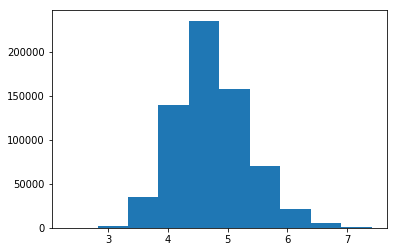

In [54]:
X_train_imputed.price.hist(grid=False);

With a normal distribution of log(price), and other normalized features, it shouldn't be too problematic to use a sample for KNN.

In [130]:
# Instantiate and fit on sample
sample = X_train_imputed.sample(25000, random_state=42)
knn_imputer = KNNImputer(n_neighbors=5, weights="distance")
knn_imputer.fit(sample)

KNNImputer(col_max_missing=0.8, copy=True, metric='masked_euclidean',
      missing_values='NaN', n_neighbors=5, row_max_missing=0.5,
      weights='distance')

In [77]:
# Create generator function to move through dataset indices
def create_indices(start, interval, maximum):
    '''
    Generates two integers separated by an interval, up to the maximum value.
    Arguments:
        start: (int) Value to begin at.
        interval: (int) Difference between first and second value to be generated.
        maximum: (int) Value to stop at.
    Returns:
        Two integers. The first equivalent to current, the second an increase of 
        the interval of the interval if lower than the maximum, or the maximum.
    '''
    current = start
    while current < maximum:
        if current + interval < maximum:
            yield current, current + interval
        else:
            yield current, maximum
        current += interval

In [131]:
# Create array on which to concatenate results
data = np.empty((0, X_train_imputed.shape[1]))

# Impute values for full dataset
for start, end in create_indices(0, 25000, X_train_imputed.shape[0]):
    results = knn_imputer.transform(X_train_imputed.iloc[start:end])
    data = np.concatenate([data, results])

C:\Users\rebecca-barnes\Anaconda3\envs\dand\lib\site-packages\missingpy\utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [132]:
X_train_final = pd.DataFrame(data, columns=X_train_imputed.columns)
# Test that length is correct
assert X_train_final.shape[0] == X_train_imputed.shape[0], \
"The shapes do not match. The values are {} and {}"\
.format(X_train_final.shape[0], X_train_imputed.shape[0])

X_train_final.head()

,price,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_communication_missing,price_missing,listing_has_picture,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,4.927978,1.830158e+09,0.0,1.0,0.0,47.674433,-122.293995,6.0,0.095310,2.0,...,0.0,0.0,1.0,4.606170,2.312535,2.208274,2.208274,2.208274,9.0,2.312535
1,6.243239,1.125712e+09,1.0,1.0,1.0,47.587694,-122.294457,4.0,0.095310,2.0,...,0.0,1.0,1.0,4.606170,2.312535,2.312535,2.312535,2.312535,10.0,2.312535
2,5.011302,2.497577e+08,0.0,1.0,1.0,47.611535,-122.314325,4.0,0.095310,1.0,...,0.0,0.0,1.0,4.533674,2.312535,2.208274,2.312535,2.312535,10.0,2.208274
3,5.011302,1.979974e+09,0.0,1.0,0.0,47.571207,-122.392049,8.0,1.131402,4.0,...,0.0,1.0,0.0,4.383276,2.312535,2.091864,2.312535,2.312535,9.0,2.091864
4,4.489759,-9.538765e+08,0.0,1.0,1.0,47.577415,-122.302300,3.0,0.095310,1.0,...,0.0,0.0,1.0,4.554929,2.208274,2.091864,2.312535,2.312535,8.0,2.208274


Let's check to make sure that all values were successfully imputed.

In [133]:
# Test: Confirm no missing values and view data distribution
assert X_train_final.isna().sum().sum() == 0
X_train_final.price.describe()

count    997063.000000
mean          4.730361
std           0.582332
min           2.312535
25%           4.329980
50%           4.683144
75%           5.075799
max           7.408591
Name: price, dtype: float64

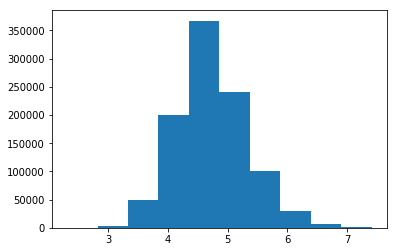

In [134]:
X_train_final.price.hist(grid=False);

The distribution of the imputed values looks very similar to the distribution before impution, so this seems successful.

In [135]:
X_train_final.to_csv('data/final_train.csv', index=False)

<a id="function"></a>
#### 6.2.7. Create engineering function

A function is required to easily replicate the feature engineering for the validation and test sets.

In [146]:
def feature_engineering(file, count_vector, mean_imputer, knn_imputer):
    '''
    Takes in a file location and completes feature engineering.
    
    Arguments:
        file: (str) File location/name.
        count_vector: CountVectorizer object fitted to training data.
        mean_imputer: Imputer object fitted to training data.
        knn_imputer: KNNImputer object fitted to training data.
    
    Returns:
        Transformed dataframe.
    '''
    # Read in dtype dictionary to avoid warnings
    dtype={"date": str, "available": int, "price": float, "id": str, "name": str, 
       "thumbnail_url": str, "host_id": str, "host_since": int, 
       "host_response_time": str, "host_is_superhost": int, 
       "host_has_profile_pic": int, "host_identity_verified": int, 
       "neighbourhood_cleansed": str, "neighbourhood_group_cleansed": str,
       "zipcode": str, "latitude": float, "longitude": float, 
       "property_type": str, "room_type": str, "accommodates": int, 
       "bathrooms": float, "bedrooms": float, "beds": float, "bed_type": str,
       "security_deposit": float, "cleaning_fee": float, "extra_people": float,
       "number_of_reviews": int, "review_scores_rating": float, 
       "review_scores_accuracy": float, "review_scoares_cleanliness": float,
       "review_scores_checkin": float, "review_scores_communication": float,
       "review_scores_location": float, "review_scores_value": float, 
       "instant_bookable": int, "cancellation_policy": str, 
       "require_guest_profile_picture": int, 
       "require_guest_phone_verification": int}
    
    # Create dataframe
    df = pd.read_csv(file, dtype=dtype, 
                     date_parser=pd.to_datetime, parse_dates=["date"])
    print(df.shape[0])
    
    ## Manage skewed data
    skewed = ['price', 'bathrooms', 'beds', 'security_deposit', 'extra_people', 
          'review_scores_rating', 'review_scores_accuracy', 
          'review_scores_cleanliness', 'review_scores_checkin', 
          'review_scores_communication', 'review_scores_value']

    df[skewed] = X_log_trans[skewed].apply(lambda x: np.log(x + 0.1))
    print("Manage skewed data:", df.shape[0])
    
    ## Manage categorical columns
    cat_cols = ['host_response_time', 'neighbourhood_cleansed', 
            'neighbourhood_group_cleansed', 'property_type', 'room_type', 
            'bed_type', 'cancellation_policy']
    # Create dummies
    df_cat_cols = pd.get_dummies(df[cat_cols], dummy_na=True)
    # Join back on
    df = pd.merge(df, df_cat_cols, left_index=True, right_index=True)
    # Drop cols
    df.drop(cat_cols, axis=1, inplace=True)
    print("Manage categorical columns:", df.shape[0])
    
    ## Create date dummies
    # Create weekday column
    df['weekday'] = df["date"].dt.dayofweek
    
    # Define seasons (end is before second date)
    summer = ('2016-06-20', '2016-09-22')
    fall = ('2016-09-22', '2016-12-21')
    winter_end_of_year = ('2016-12-21', '2017-03-20')
    winter_start_of_year = ('2016-01-01', '2016-03-19')
    spring = ('2016-03-19', '2016-06-20')

    # Create list of seasons and names
    seasons = [summer, fall, spring]
    names = ['summer', 'fall', 'spring']

    # Create season columns
    for season, name in zip(seasons, names):
        df[name] = (season[0] <= df["date"]) & (df["date"] < season[1])

        df['winter'] = ((winter_end_of_year[0] <= df["date"]) \
                        & (df["date"] < winter_end_of_year[1])) \
            | ((winter_start_of_year[0] <= df["date"]) \
               & (df["date"] < winter_start_of_year[1]))
    print("Create season columns:", df.shape[0])
    
    # Collect federal/state holidays
    new_year = ['new_year', 'Friday', '2016-01-01']
    mlk = ['mlk', 'Monday', '2016-01-16']
    presidents = ['presidents', 'Monday', '2016-02-15']
    memorial = ['memorial', 'Monday', '2016-05-30']
    fourth_july = ['fourth_july', 'Monday', '2016-07-04']
    labor = ['labor', 'Monday', '2016-09-05']
    veteran = ['veteran', 'Friday', '2016-11-11']
    thanksgiving = ['thanksgiving', 'Thursday', '2016-11-24']
    christmas = ['christmas', 'Monday', '2016-12-26']

    holidays = [new_year, mlk, presidents, memorial, fourth_july, labor, 
                veteran, thanksgiving, christmas]

    # Define start and end for each holiday
    for holiday in holidays:
        hol_date = datetime.strptime(holiday[2], '%Y-%m-%d')
        if holiday[1] == 'Monday':
            # Start date is the Friday before
            holiday.append(hol_date - timedelta(days=3))
            # End date is the day after
            holiday.append(hol_date + timedelta(days=1))
        if holiday[1] == 'Friday':
            # Start date is the day before
            holiday.append(hol_date - timedelta(days=1))
            # End date is the Monday after
            holiday.append(hol_date + timedelta(days=3))
        if holiday[1] == 'Thursday':
            # Start date is the day before
            holiday.append(hol_date - timedelta(days=1))
            # End date is the Monday after
            holiday.append(hol_date + timedelta(days=4))

    # Create holiday columns
    for holiday in holidays:
        df[holiday[0]] = (holiday[-2] <= df["date"]) & (df["date"] < holiday[-1])
    print("Create holiday columns:", df.shape[0])
    
    # Collect school holidays
    winter_break = ['winter_break', '2016-12-19', '2017-01-02']
    mid_winter_break = ['mid_winter_break', '2016-02-15', '2016-02-22']
    spring_break = ['spring_break', '2016-04-11', '2016-04-18']
    summer_break = ['summer_break', '2016-06-22', '2016-09-07']

    school_hols = [winter_break, mid_winter_break, spring_break, summer_break]
    
    # Create school holiday columns
    for holiday in school_hols:
        df[holiday[0]] = (holiday[1] <= df["date"]) & (df["date"] < holiday[2])
        
    # Drop date column
    df.drop("date", axis=1, inplace=True)
    print("Create date dummies:", df.shape[0])
    
    ## Extract text from names
    # Fit count_vector and get list of features
    word_count = count_vector.transform(df["name"])
    words = count_vector.get_feature_names()

    # Convert word_count to df, inc. indication of name content
    word_df = pd.DataFrame(word_count.todense(), index=df.index,
                           columns=['name_' + word for word in words])

    # Merge with original df and drop 'name column'
    df = pd.concat([df, word_df], axis=1)
    df.drop('name', axis=1, inplace=True)
    print("Extract text from names:", df.shape[0])
    
    ## Manage missing values
    # Fill na with 0 for security deposit and cleaning fee
    df.loc[:, ['security_deposit', 'cleaning_fee']] = \
    df[['security_deposit', 'cleaning_fee']].fillna(0)
    
    # Create dummy columns for missing ratings and price
    missing_cols = ['review_scores_rating', 'review_scores_accuracy', 
               'review_scores_cleanliness', 'review_scores_checkin', 
               'review_scores_location', 'review_scores_value', 
               'review_scores_communication', 'price']
    
    for col in missing_cols:
        df[col + '_missing'] = df[col].isna()
    
    # Create dummy column for missing picture
    df['listing_has_picture'] = ~(df['thumbnail_url'].isna())
    
    # Drop no longer necessary columns
    df.drop(['id', 'thumbnail_url', 'zipcode', 'host_id'], axis=1, inplace=True)
    print("Fill and dummy missing values:", df.shape[0])
    
    # Impute ratings
    ratings_cols = df.loc[:, "review_scores_rating":"review_scores_value"].columns
    imputed_ratings = mean_imputer.transform(df[ratings_cols])

    # Join back onto df
    ratings_df = pd.DataFrame(imputed_ratings, columns=ratings_cols, 
                              index=df.index)
    df.drop(ratings_cols, axis=1, inplace=True)
    df = pd.concat([df, ratings_df], axis=1)
    print("Impute means for ratings:", df.shape[0])
    
    # Create empty array for imputing
    data = np.empty((0, X_train_imputed.shape[1]))
    
    # Impute prices
    for start, end in create_indices(0, 25000, df.shape[0]):
        results = knn_imputer.transform(df.iloc[start:end])
        data = np.concatenate([data, results])
    print("Impute prices:", df.shape[0])
    
    ## Create final df
    df = pd.DataFrame(data, columns=df.columns, index=df.index)

    return df

<a id="model"></a>
## 7. Model

So that all wrangling is complete and saved I'm going to read in and format both the validation and test datasets for X.

In [147]:
# Read in validation set
X_valid_final = feature_engineering("data/X_valid.csv", count_vector, 
                                    mean_imputer, knn_imputer)

249266


C:\Users\rebecca-barnes\Anaconda3\envs\dand\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: invalid value encountered in log


Manage skewed data: 249266
Manage categorical columns: 249266
Create season columns: 249266
Create holiday columns: 249266
Create date dummies: 249266
Extract text from names: 249266
Fill and dummy missing values: 249266
Impute means for ratings: 249266


C:\Users\rebecca-barnes\Anaconda3\envs\dand\lib\site-packages\missingpy\utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Impute prices: 249266


In [138]:
X_valid_final.to_csv("data/final_valid.csv", index=False)

In [139]:
# Read in test set
X_test_final = feature_engineering("data/X_test.csv", count_vector, 
                                    mean_imputer, knn_imputer)

C:\Users\rebecca-barnes\Anaconda3\envs\dand\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in log
C:\Users\rebecca-barnes\Anaconda3\envs\dand\lib\site-packages\missingpy\utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [140]:
X_test_final.head()

,price,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_communication_missing,price_missing,listing_has_picture,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,1.615018,1.713504e+09,1.0,1.0,1.0,47.626405,-122.358380,4.0,-1.633166,1.0,...,0.0,0.0,1.0,1.548874,0.880678,0.836500,0.836500,0.836500,10.000000,0.880678
1,3.983679,-1.153434e+09,0.0,1.0,1.0,47.527318,-122.277909,2.0,-1.633166,1.0,...,0.0,1.0,1.0,1.548874,0.880678,0.880678,0.880678,0.880678,9.610486,0.880678
2,1.631454,-1.968177e+09,0.0,1.0,1.0,47.671199,-122.315093,6.0,-1.633166,2.0,...,0.0,0.0,1.0,1.533350,0.880678,0.836500,0.880678,0.880678,9.000000,0.836500
3,4.287844,9.918218e+08,0.0,1.0,1.0,47.610281,-122.295744,3.0,0.208153,0.0,...,0.0,1.0,1.0,1.500354,0.880678,0.784752,0.880678,0.880678,8.000000,0.784752
4,1.523828,9.733407e+08,0.0,1.0,1.0,47.666062,-122.296492,1.0,-1.633166,1.0,...,0.0,0.0,1.0,1.537927,0.836500,0.784752,0.880678,0.880678,10.000000,0.836500


In [141]:
X_test_final.to_csv("data/final_test.csv", index=False)

Before using any of this data to model, the final thing that needs to be done is to scale the data.

In [142]:
# Instantiate
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train_final)

# Fit validation and test data
X_valid_scaled = scaler.transform(X_valid_final)
X_test_scaled = scaler.transform(X_test_final)

In [143]:
# Save datasets
datasets = [X_train_scaled, X_valid_scaled, X_test_scaled]
names = ["X_train_scaled", "X_valid_scaled", "X_test_scaled"]
folder = "data"

for dataset, name in zip(datasets, names):
    df = pd.DataFrame(dataset, columns=X_train_final.columns)
    df.to_csv(os.path.join(folder, name + ".csv"), index=False)

<a id="select"></a>
### 7.1. Metrics and Model Selection

#### 7.1.1. Metrics
When considering the metric to use to assess the models, there are a few things to consider: the number of classes, the class imbalance and the priority for prediction.

In this case there are only two classes to predict, so that is less of a consideration. The classes do have some imbalance with a 2:1 ratio of availability to non-availability but it is not as extreme as in cases of fraud detection. 

In terms of prediction, the priority is that if we say that the place is available, it is. It is also helpful to find all of the available listings. That seems to favor the F-score above the ROC-AUC score but I might keep track of both just for the sake of it. I'd like to weight slightly more towards precision so I'll weight with ${\beta}$ = 0.3.

#### 7.1.2. Model
The three models I'd like to compare are Random Forest, Gradient Boosting, and SVC. 

There's a couple of reasons for this. I'd like to be able to identify some of the more important features for prediction to be able to assit with the business case. But I'm also interested in the raw prediction ability. So I'd like to do some comparisons between, at least initially.

<a id="initial"></a>
### 7.2. Initial Evaluation

To easily compare the untuned algorithms and their performance, let's create a function.

In [179]:
def model_stats(learner, sample_size, beta, X_train, y_train, X_valid, y_valid):
    '''
    Collects algorithm performance statistics.
    
    Arguments:
        learner: The learning algorithm to used.
        samples_sizes: List of sample sizes to be used.
        X_train: Features training set.
        y_train: Response training set.
        X_valid: Features validation set.
        y_train: Response validation set.
    Returns:
        results: Dict of f-scores and roc-auc-scores.
    '''
    results = {}
    
    # Fit on sample size
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    # Predict first 500 samples
    pred_train = learner.predict(X_train[:500])
    pred_valid = learner.predict(X_valid[:500])
    
    # Collect metrics
    results['f_train'] = fbeta_score(y_train[:500], pred_train, beta)
    results['f_valid'] = fbeta_score(y_valid[:500], pred_valid, beta)
    results['roc_train'] = roc_auc_score(y_train[:500], pred_train)
    results['roc_valid'] = roc_auc_score(y_valid[:500], pred_valid)
    
    # Include progression indicator
    print("{} trained on {} samples.".format(learner.__class__.__name__, 
                                                 sample_size))
    
    return results

In [184]:
# Model setup
clf_rf = RandomForestClassifier(random_state=42)
clf_gb = GradientBoostingClassifier(random_state=42)
clf_svc = SVC(random_state=42)

# Read in responses
y_train = pd.read_csv("data/y_train.csv", header=None).values.ravel()
y_valid = pd.read_csv("data/y_valid.csv", header=None).values.ravel()

# Confirm correct sizes
assert len(y_train) == X_train_scaled.shape[0], \
"Shapes don't match. First is {}, second is {}."\
.format(len(y_train), X_train_scaled.shape[0])

assert len(y_valid) == X_valid_scaled.shape[0], \
"Shapes don't match. First is {}, second is {}."\
.format(len(y_valid), X_valid_scaled.shape[0])

# Set sample sizes
sample_100 = len(y_train)
sample_50 = int(sample_100*0.5)
sample_30 = int(sample_100*0.3)
sample_10 = int(sample_100*0.1)
sample_01 = int(sample_100*0.01)
sample_sizes = [sample_01, sample_10, sample_30, sample_50, sample_100]
names = ["1%", "10%", "30%", "50%", "100%"]

# Collect results on learners
results = {}
for clf in [clf_rf, clf_gb, clf_svc]:
    # Assign results per clf and sample size
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for name, sample_size in zip(names, sample_sizes):
        results[clf_name][name] = \
        model_stats(clf, sample_size, 0.3, X_train_scaled, y_train, 
                    X_valid_scaled, y_valid)

RandomForestClassifier trained on 9970 samples.
RandomForestClassifier trained on 99706 samples.
RandomForestClassifier trained on 299118 samples.
RandomForestClassifier trained on 498531 samples.
RandomForestClassifier trained on 997063 samples.
GradientBoostingClassifier trained on 9970 samples.
GradientBoostingClassifier trained on 99706 samples.
GradientBoostingClassifier trained on 299118 samples.
GradientBoostingClassifier trained on 498531 samples.
GradientBoostingClassifier trained on 997063 samples.
SVC trained on 9970 samples.
SVC trained on 99706 samples.
SVC trained on 299118 samples.
SVC trained on 498531 samples.
SVC trained on 997063 samples.


Some quick observations on time - The Random Forest classifier went quite quickly, even at training on almost 1M samples. The Gradient Boosting classifer was slower than the RF, but faster than SVC.

The SVC is much slower - the training took _much_ longer than the other two.

Let's have a look at the results.

In [247]:
# Define a function to plot metrics
def plot_score(data, first_line, second_line, title):
    loc = [.01, .10, .30, .50, 1.00]
    plt.plot(loc, data.loc[first_line], label=first_line)
    plt.plot(loc, data.loc[second_line], label=second_line)
    plt.xticks(loc, data.columns)
    plt.ylim([0, 1.1])
    plt.legend()
    plt.title(title)
    plt.xlabel("Sample Size")
    plt.ylabel("Score");

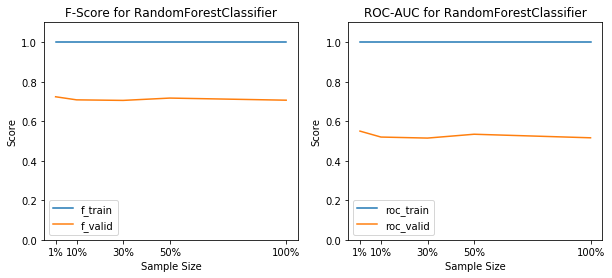

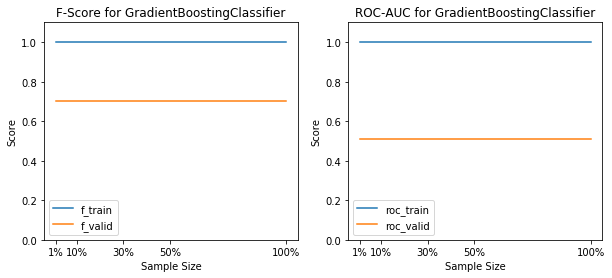

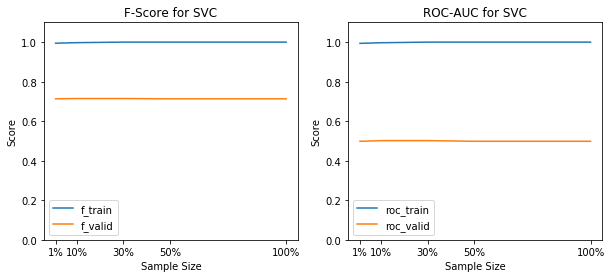

In [253]:
for clf in results:
    cols = ["1%", "10%", "30%", "50%", "100%"]
    clf_df = results[clf][cols]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plot_score(clf_df, "f_train", "f_valid", "F-Score for {}".format(clf))
    plt.subplot(1, 2, 2)
    plot_score(clf_df, "roc_train", "roc_valid", "ROC-AUC for {}".format(clf))

We can see that there is a large amount of overfitting for each model at this time, which is not that suprising given that the default settings have been used. There are a couple of interesting thigs to note: even at 1% of the data, there are enough data points for overfitting to have occurred. The scores for each model on both F-Score and ROC are incredibly consistent across the models, suggesting that their final predictions are similar. 

Just to see what is being predicted, it might be worth looking at a confusion matrix. (Plotting resource from [sci-kit learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [267]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization
[[ 52  99]
 [109 240]]


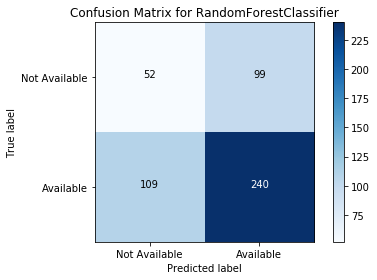

Confusion matrix, without normalization
[[ 51 100]
 [110 239]]


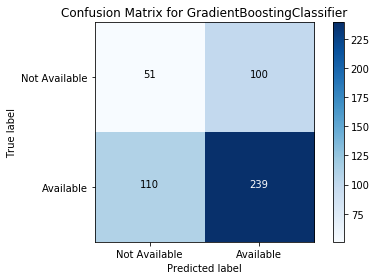

In [268]:
# Predict on most recently trained RF GB classifiers for confusion matrix
for clf in [clf_rf, clf_gb]:
    preds = clf.predict(X_valid_scaled[:500])
    cm = confusion_matrix(y_valid[:500], preds)
    plot_confusion_matrix(cm, classes=["Not Available", "Available"], 
                          title="Confusion Matrix for {}".format(clf.__class__.__name__))

Normalized confusion matrix
[[0.34437086 0.65562914]
 [0.31232092 0.68767908]]


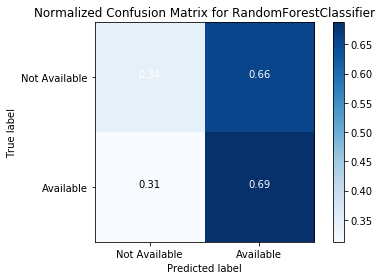

Normalized confusion matrix
[[0.33774834 0.66225166]
 [0.31518625 0.68481375]]


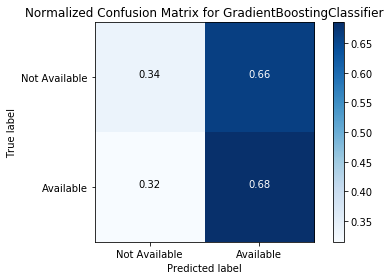

In [269]:
# Look at rates
for clf in [clf_rf, clf_gb]:
    preds = clf.predict(X_valid_scaled[:500])
    cm = confusion_matrix(y_valid[:500], preds)
    plot_confusion_matrix(cm, classes=["Not Available", "Available"], 
                          normalize=True, 
                          title="Normalized Confusion Matrix for {}".format(clf.__class__.__name__))

It looks like we are doing quite well with the prediction of the available listings, but less well with the prediction of the unavailable listings, which explains the lower ROC-AUC score. The leaning towards predicting as available also suggests that there may not be the need to weight the F-score, so for further assessment I'll just do a standard F score. 

Given the much longer training times for SVC. I'm going to stick with tuning the RF and GB classifiers. 